In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
from prettytable import PrettyTable

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [2]:
path = '/Users/tristangarcia/desktop/hp-pred/data/wa/'

# Loading files
train = pd.read_pickle(f'{path}wa_train_final.pkl')
test = pd.read_pickle(f'{path}wa_validation_final.pkl')

x_train = train.drop(columns=['soldPrice'])
y_train = train['soldPrice']

x_test = test.drop(columns=['soldPrice'])
y_test = test['soldPrice']

# Utility Functions

In [3]:
# Used to keep track of model results for different models
results = {'model':[], 'MSE':[], 'MAE':[], 'R2':[]}

def add_model_results(model_name, mse, mae, r2):
    results['model'].append(model_name)
    results['MSE'].append(mse)
    results['MAE'].append(mae)
    results['R2'].append(r2)

In [4]:
def calculate_regression_metrics(y_true, y_pred):
    """
    Calculate regression metrics: MSE, RMSE, MAE, MAPE, and R-squared.
    """
    mse = round(mean_squared_error(y_true, y_pred), 4)
    rmse = round(np.sqrt(mse), 4)  # Calculate RMSE
    mae = round(mean_absolute_error(y_true, y_pred), 4)
    mape = round(np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100, 4)  # Avoid division by zero
    r2 = round(r2_score(y_true, y_pred), 4)
    return mse, rmse, mae, mape, r2

def print_regression_results_table(train_results, test_results, model_name):
    """
    Print regression results in a PrettyTable for train and test datasets.
    """
    table = PrettyTable()
    table.field_names = ['Dataset', 'Model', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2']
    
    # Unpack train and test results
    train_mse, train_rmse, train_mae, train_mape, train_r2 = train_results
    test_mse, test_rmse, test_mae, test_mape, test_r2 = test_results
    
    table.add_row(['Train', model_name, train_mse, train_rmse, train_mae, train_mape, train_r2])
    table.add_row(['Test', model_name, test_mse, test_rmse, test_mae, test_mape, test_r2])
    print(table)

def plot_predictions(y_true_train, y_pred_train, y_true_test, y_pred_test):
    """
    Plot predictions vs. actual values for train and test datasets.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
    sns.scatterplot(x=y_true_train, y=y_pred_train, ax=axes[0], color="blue", alpha=0.7)
    axes[0].plot([min(y_true_train), max(y_true_train)], [min(y_true_train), max(y_true_train)], 'r--')
    axes[0].set_title("Train: Actual vs. Predicted")
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predicted")
    
    sns.scatterplot(x=y_true_test, y=y_pred_test, ax=axes[1], color="green", alpha=0.7)
    axes[1].plot([min(y_true_test), max(y_true_test)], [min(y_true_test), max(y_true_test)], 'r--')
    axes[1].set_title("Test: Actual vs. Predicted")
    axes[1].set_xlabel("Actual")
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, x_train, y_train, x_test, y_test, model_name):
    """ 
    Evaluate regression model performance on train and test datasets.
    """
    # Train the model
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    # Calculate metrics for train set
    train_results = calculate_regression_metrics(y_train, y_train_pred)
    
    # Calculate metrics for test set
    test_results = calculate_regression_metrics(y_test, y_test_pred)
    
    # Print results in a table
    print_regression_results_table(train_results, test_results, model_name)
    
    # Plot predictions vs. actual
    plot_predictions(y_train, y_train_pred, y_test, y_test_pred)
    
    return model

In [5]:
def hyperparameter_tune(regressor, param_grid, X, y):
    '''
    Perform hyperparameter tuning for regression with:
    - 5-fold cross-validation
    - multiple scoring functions
    - recorded total time
    - refit based on Mean Absolute Error (MAE)
    '''
    # Cross-validation strategy
    cv = KFold(n_splits=5, shuffle=True, random_state=123)
    
    # Multiple scoring functions
    scoring = {
        'mse': make_scorer(mean_squared_error, greater_is_better=False),
        'r2': 'r2',
        'mae': make_scorer(mean_absolute_error, greater_is_better=False)  
    }
    
    start_time = time.time()  # Starting time
    
    # GridSearch with refit set to 'mae'
    tuned_model = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring=scoring, 
                               refit='mae', cv=cv, verbose=2, return_train_score=True, n_jobs=1)
    tuned_model.fit(X, y)
    
    end_time = time.time()  # End time
    print(f'Total time taken: {(end_time - start_time):.2f} seconds')

    # Output the results
    print(f"Best params: {tuned_model.best_params_}")
    print(f"Best estimator: {tuned_model.best_estimator_}")
    print(f"Best MAE: {tuned_model.best_score_:.4f}") 
    
    return tuned_model

In [6]:
def plot_search_results(tuned_model):
    """
    Plot the results of hyperparameter tuning for regression models based on MAE.
    
    Params: 
        tuned_model: A trained GridSearchCV object.
    """
    # Results from grid search
    results = tuned_model.cv_results_
    means_test = results['mean_test_mae']
    stds_test = results['std_test_mae']
    means_train = results['mean_train_mae']
    stds_train = results['std_train_mae']

    params = tuned_model.param_grid
    param_names = list(params.keys())

    # Case 1: More than two hyperparameters
    if len(params) > 2:
        fig, axes = plt.subplots(1, len(params), sharey=True, figsize=(20, 5))
        fig.suptitle('Score per Parameter')
        fig.text(0.04, 0.5, 'Mean MAE', va='center', rotation='vertical')

        for i, param_name in enumerate(param_names):
            masks = [results[f'param_{p}'].data == tuned_model.best_params_[p] for p in param_names if p != param_name]
            combined_mask = np.logical_and.reduce(masks)
            indices = np.where(combined_mask)[0]

            x = np.array(params[param_name])
            y_test = np.array(means_test[indices])
            e_test = np.array(stds_test[indices])
            y_train = np.array(means_train[indices])
            e_train = np.array(stds_train[indices])

            axes[i].errorbar(x, y_test, e_test, linestyle='--', marker='o', label='Test')
            axes[i].errorbar(x, y_train, e_train, linestyle='-', marker='^', label='Train')
            axes[i].set_xlabel(param_name.upper())
        
        plt.legend()
        plt.show()

    # Case 2: Exactly two hyperparameters
    elif len(params) == 2:
        param1, param2 = param_names
        param1_values = params[param1]
        param2_values = params[param2]
        
        # Reshape scores into 2D grids
        train_scores = means_train.reshape(len(param1_values), len(param2_values))
        test_scores = means_test.reshape(len(param1_values), len(param2_values))
        
        # Plot heatmaps
        fig, (train_ax, test_ax) = plt.subplots(1, 2, figsize=(20, 5))
        
        sns.heatmap(train_scores, cmap='Greens', annot=True, fmt='.4f', ax=train_ax,
                    xticklabels=param2_values, yticklabels=param1_values)
        train_ax.set_title("Train MAE Heatmap")
        train_ax.set_xlabel(param2)
        train_ax.set_ylabel(param1)

        sns.heatmap(test_scores, cmap='Blues', annot=True, fmt='.4f', ax=test_ax,
                    xticklabels=param2_values, yticklabels=param1_values)
        test_ax.set_title("Test MAE Heatmap")
        test_ax.set_xlabel(param2)
        test_ax.set_ylabel(param1)

        plt.show()

    # Case 3: Exactly one hyperparameter
    elif len(params) == 1:
        param_name = param_names[0]
        param_values = params[param_name]

        plt.figure(figsize=(10, 5))
        plt.plot(param_values, means_train, label="Train")
        plt.plot(param_values, means_test, label="Test")

        # Add annotations for train data
        for i, value in enumerate(means_train):
            plt.annotate((param_values[i], round(value, 3)), (param_values[i], means_train[i]))

        # Add annotations for test data
        for i, value in enumerate(means_test):
            plt.annotate((param_values[i], round(value, 3)), (param_values[i], means_test[i]))

        plt.xlabel(param_name.upper())
        plt.ylabel('MAE')
        plt.grid()
        plt.legend()
        plt.show()

In [7]:
def plot_feature_importance(model_trained, x_train, model_name):
    # Only for randomforest and xgboost (maybe gbm but haven't tried)
    # Extract feature importance
    importance_df = pd.DataFrame({
        'Feature': x_train.columns,
        'Importance': model_trained.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(20, 20))
    sns.barplot(data=importance_df, x='Importance', y='Feature', palette="viridis", 
                hue='Feature', dodge=False, legend=False)
    plt.title(f"Feature Importance ({model_name})")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

# Modelling

### k Nearest Neighbours

+---------+-------+--------+--------+--------+--------+--------+
| Dataset | Model |  MSE   |  RMSE  |  MAE   |  MAPE  |   R2   |
+---------+-------+--------+--------+--------+--------+--------+
|  Train  |  KNN  | 0.0065 | 0.0806 | 0.0584 | 0.9942 | 0.8643 |
|   Test  |  KNN  | 0.0099 | 0.0995 | 0.0723 | 1.2309 | 0.7993 |
+---------+-------+--------+--------+--------+--------+--------+


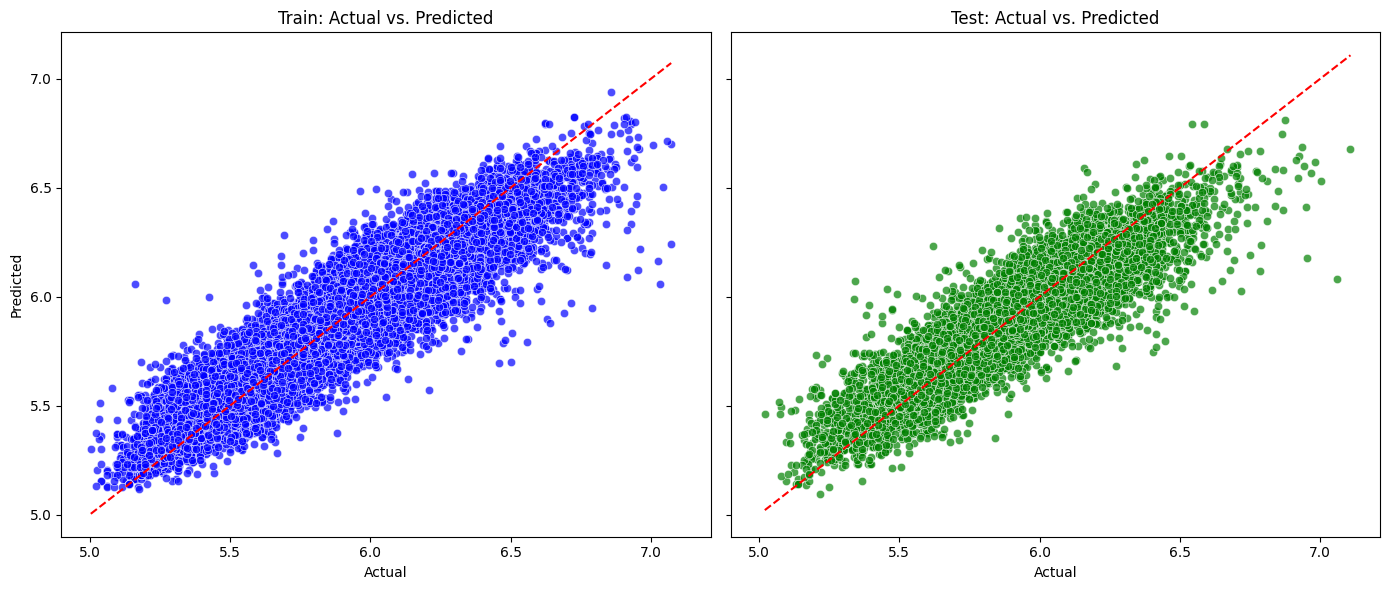

In [8]:
knn = KNeighborsRegressor()
knn_trained = evaluate_model(knn, x_train, y_train, x_test, y_test, 'KNN')

### Random Forest

+---------+-------+--------+--------+--------+--------+--------+
| Dataset | Model |  MSE   |  RMSE  |  MAE   |  MAPE  |   R2   |
+---------+-------+--------+--------+--------+--------+--------+
|  Train  |   RF  | 0.001  | 0.0316 | 0.0229 | 0.3909 | 0.9785 |
|   Test  |   RF  | 0.0068 | 0.0825 | 0.0601 | 1.025  | 0.8611 |
+---------+-------+--------+--------+--------+--------+--------+


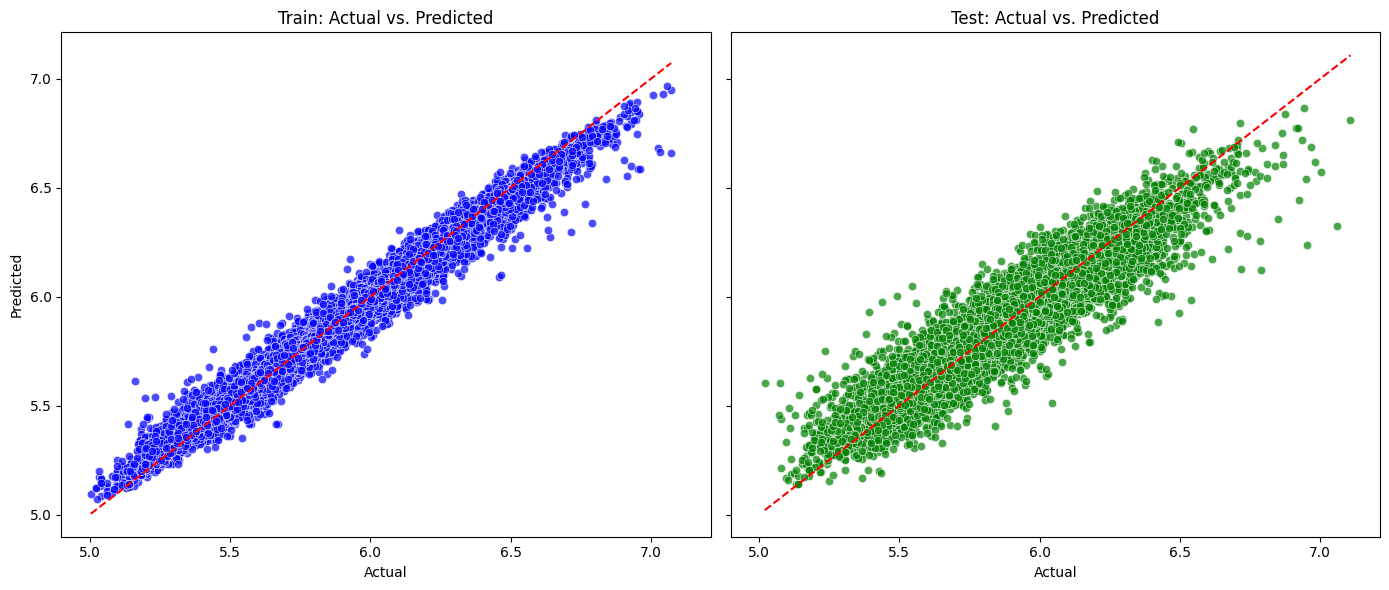

In [9]:
rf = RandomForestRegressor()
rf_trained = evaluate_model(rf, x_train, y_train, x_test, y_test, 'RF')

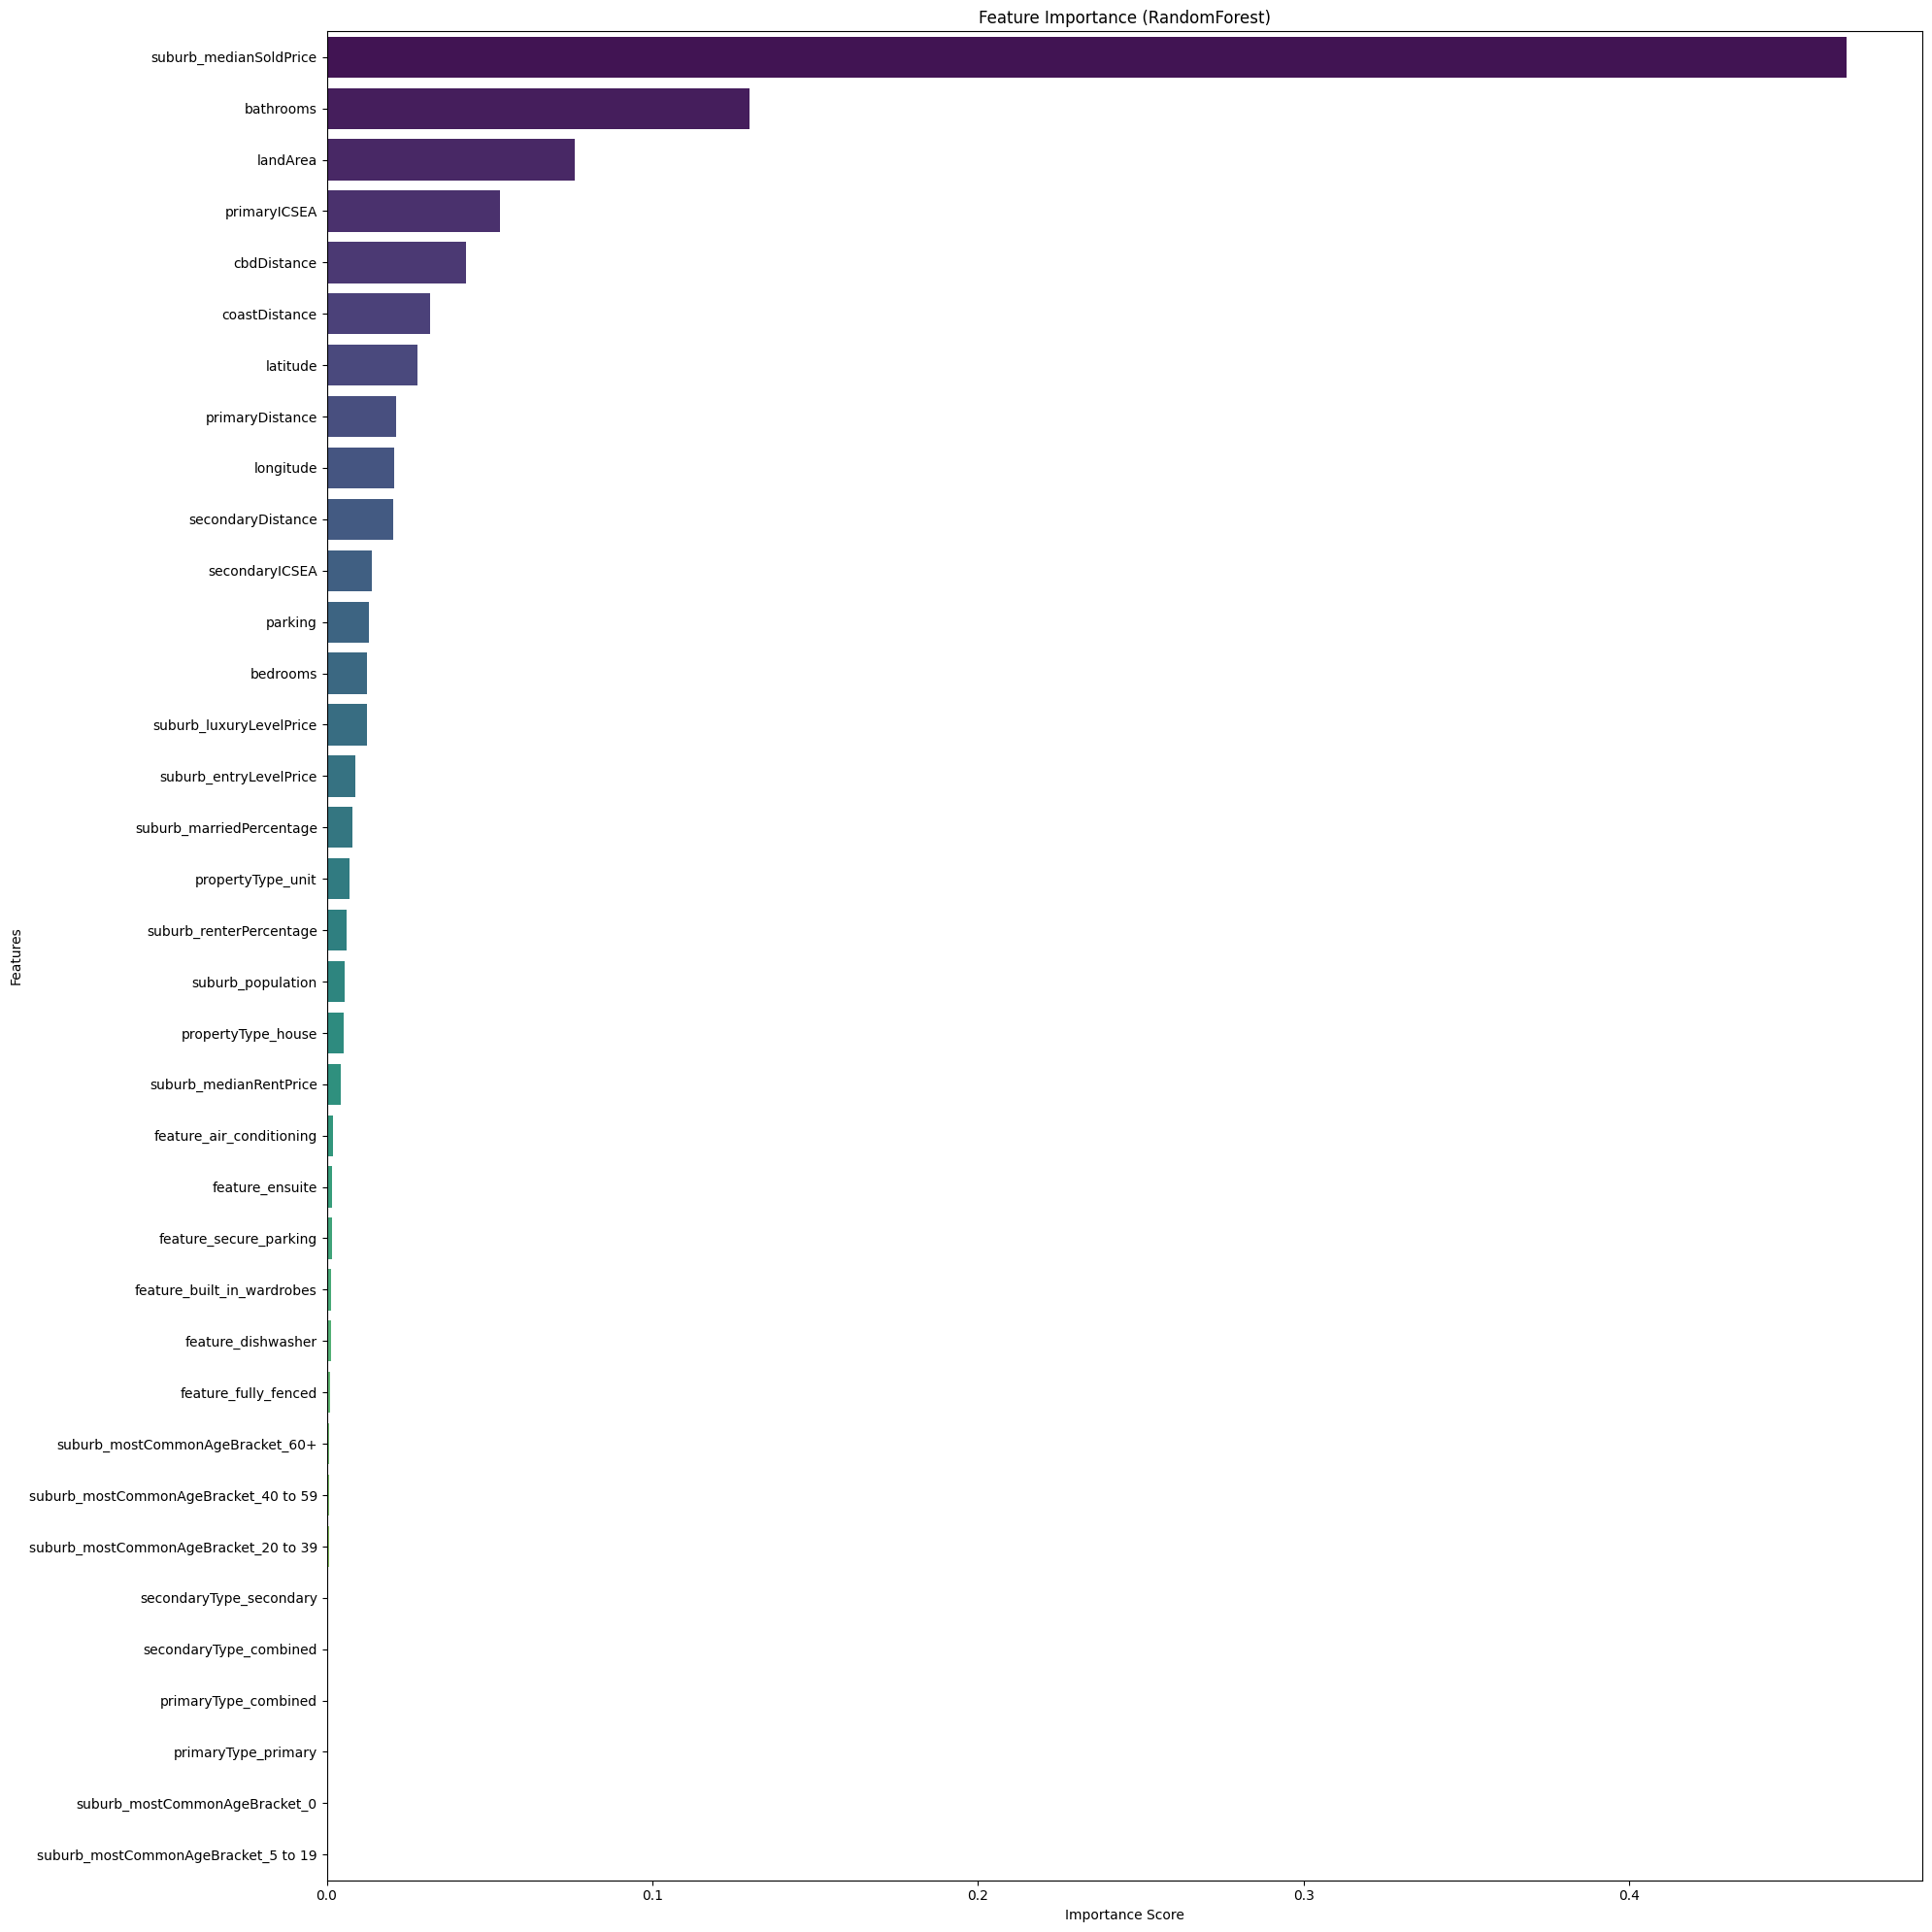

In [10]:
plot_feature_importance(rf_trained, x_train, 'RandomForest')

### XGBoost

+---------+-------+--------+--------+--------+--------+--------+
| Dataset | Model |  MSE   |  RMSE  |  MAE   |  MAPE  |   R2   |
+---------+-------+--------+--------+--------+--------+--------+
|  Train  |  XGB  | 0.006  | 0.0775 | 0.058  | 0.9923 | 0.8754 |
|   Test  |  XGB  | 0.0071 | 0.0843 | 0.0628 | 1.0729 | 0.8552 |
+---------+-------+--------+--------+--------+--------+--------+


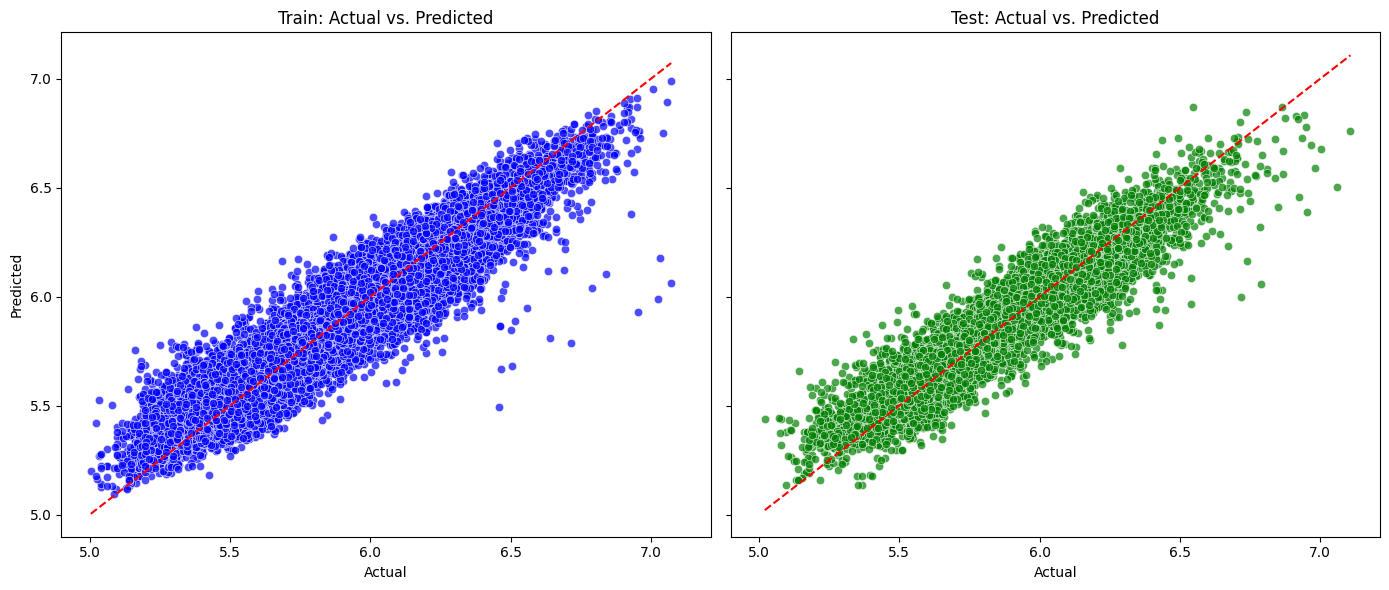

In [11]:
xgb = XGBRegressor()
xgb_trained = evaluate_model(xgb, x_train, y_train, x_test, y_test, 'XGB')

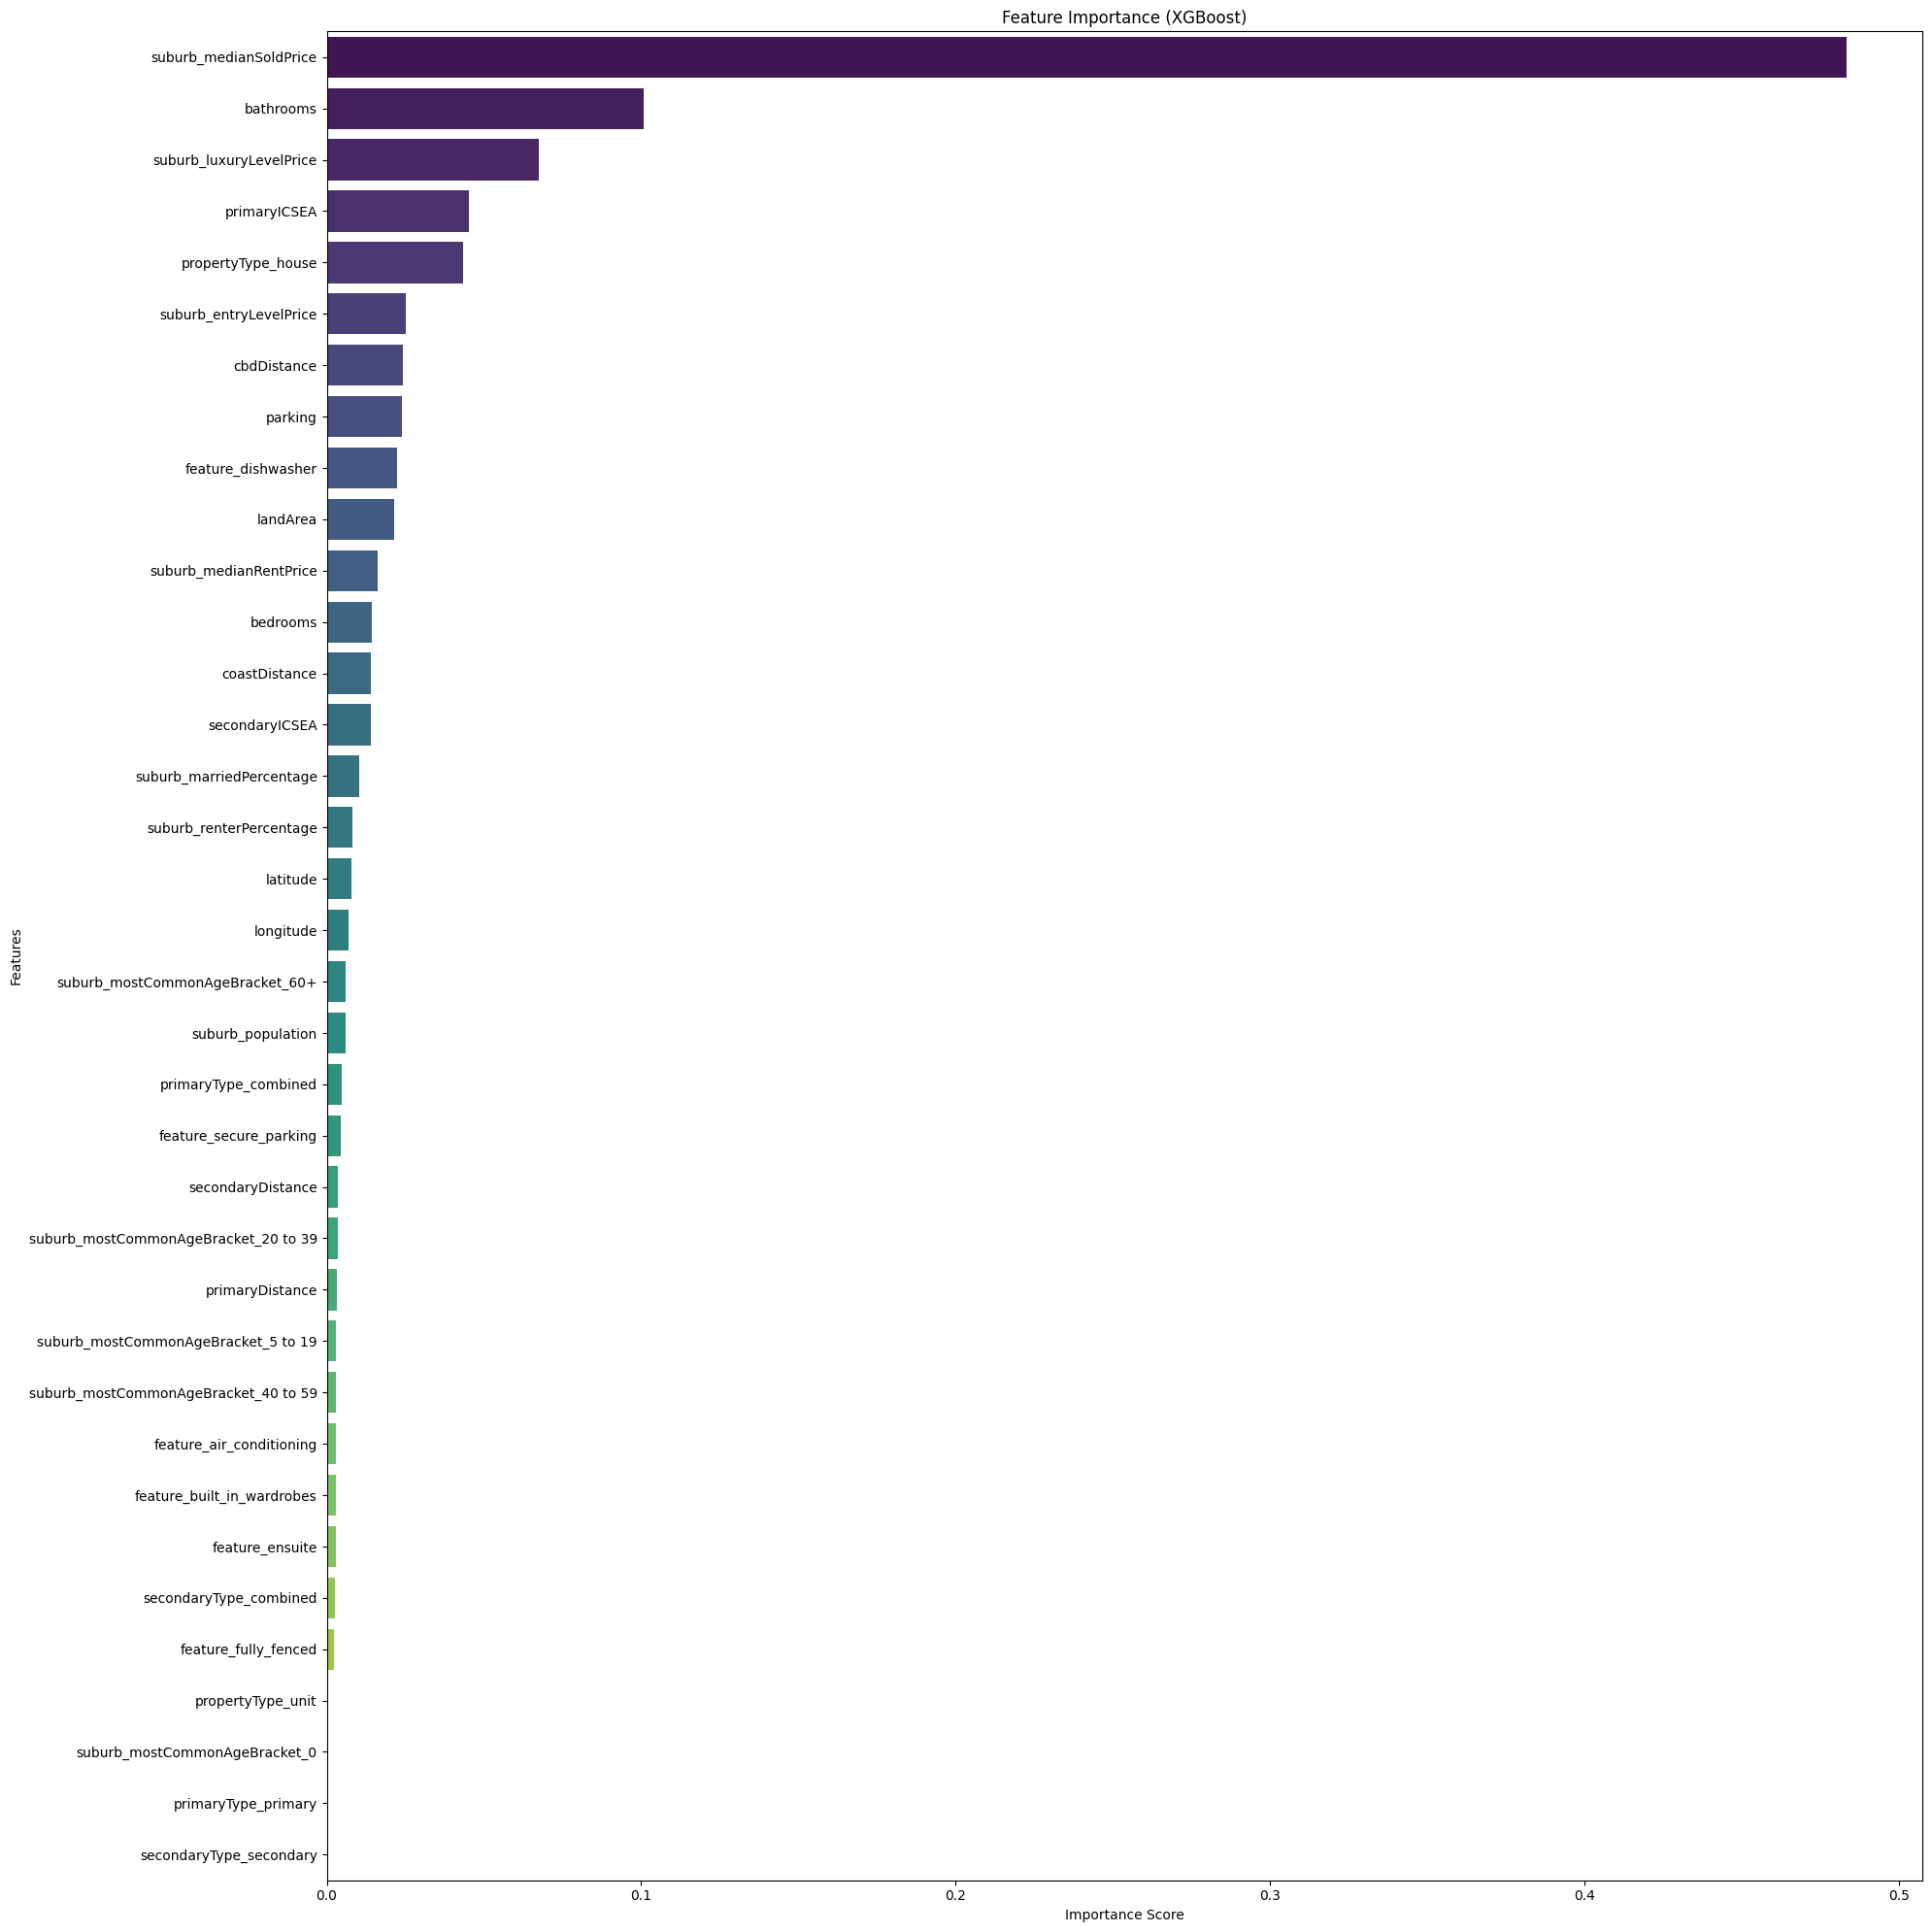

In [12]:
plot_feature_importance(xgb_trained, x_train, 'XGBoost')

# Evaluating Models
Looking at the trained models, it seems that house features have very little importance/predictive power. We will disclude this in the next models and see if it get better

In [13]:
# Filtering out columns that begin with feature_
x_train2 = x_train.drop(columns=x_train.filter(regex='^feature_').columns).copy()
x_test2 = x_test.drop(columns=x_test.filter(regex='^feature_').columns).copy()

### k Nearest Neighbours

+---------+-------+--------+--------+--------+--------+--------+
| Dataset | Model |  MSE   |  RMSE  |  MAE   |  MAPE  |   R2   |
+---------+-------+--------+--------+--------+--------+--------+
|  Train  |  KNN  | 0.0061 | 0.0781 | 0.0563 | 0.9588 | 0.8729 |
|   Test  |  KNN  | 0.0092 | 0.0959 | 0.0692 | 1.1798 | 0.8135 |
+---------+-------+--------+--------+--------+--------+--------+


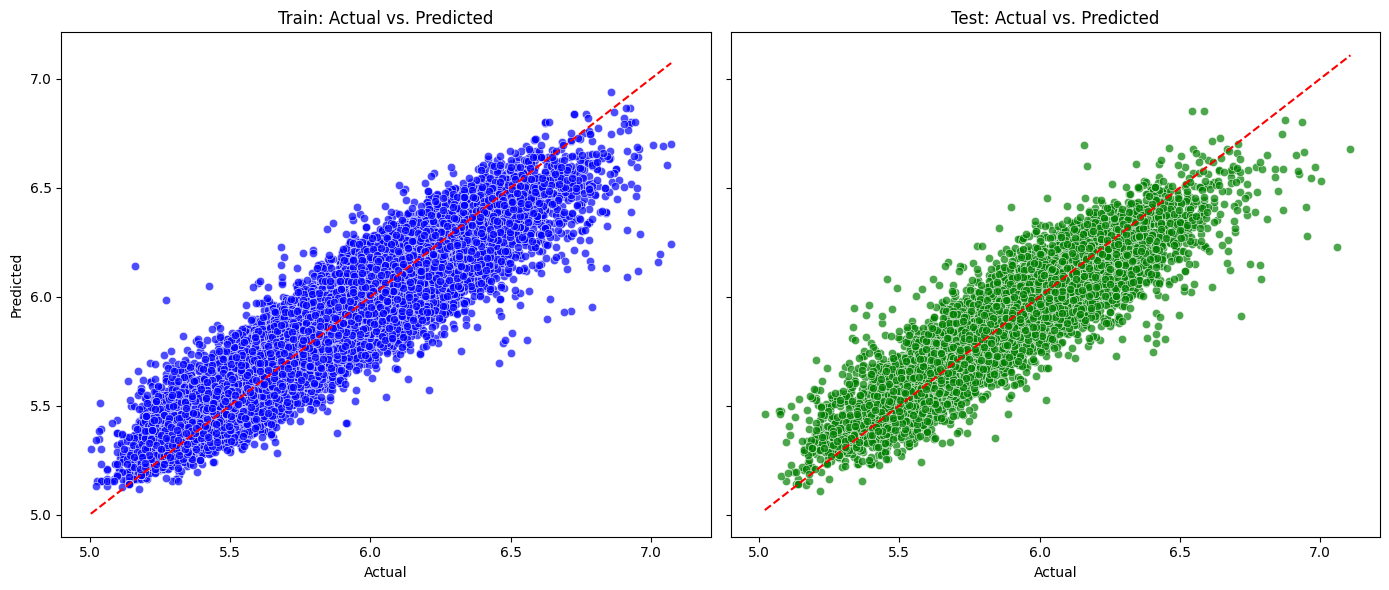

In [14]:
knn = KNeighborsRegressor()
knn_trained = evaluate_model(knn, x_train2, y_train, x_test2, y_test, 'KNN')

### Random Forest

+---------+-------+--------+--------+--------+--------+--------+
| Dataset | Model |  MSE   |  RMSE  |  MAE   |  MAPE  |   R2   |
+---------+-------+--------+--------+--------+--------+--------+
|  Train  |   RF  | 0.0011 | 0.0332 | 0.0234 | 0.4001 | 0.9776 |
|   Test  |   RF  | 0.0069 | 0.0831 | 0.0606 | 1.0342 | 0.8595 |
+---------+-------+--------+--------+--------+--------+--------+


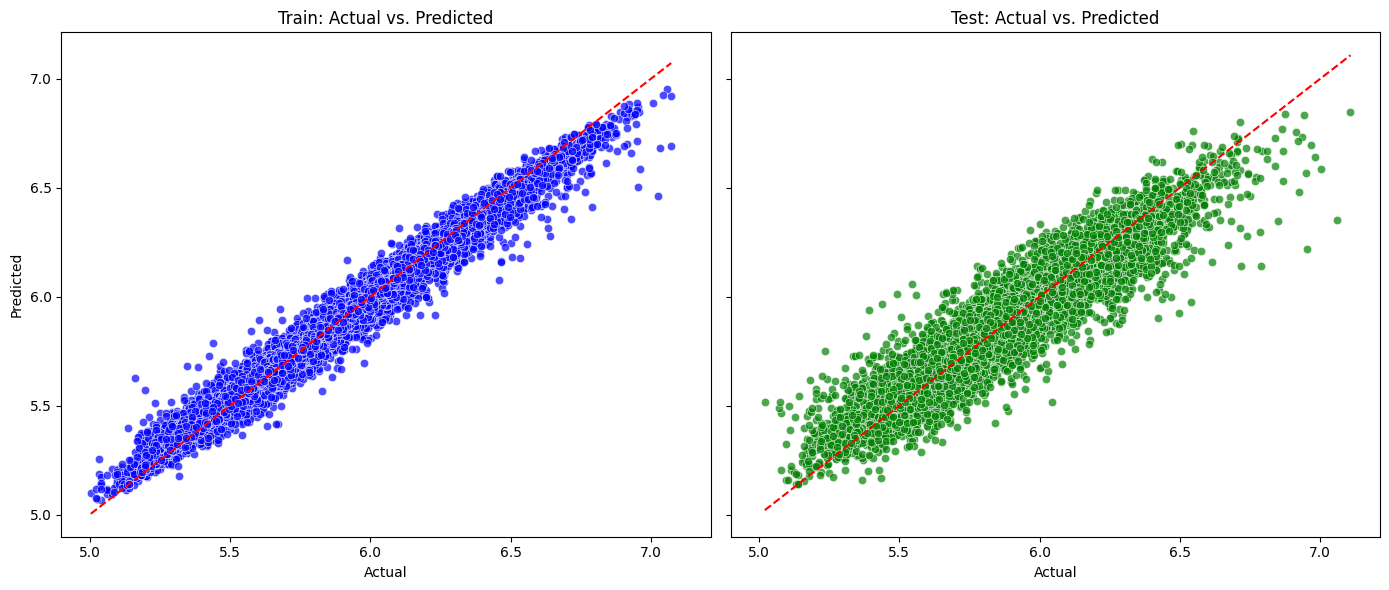

In [15]:
rf = RandomForestRegressor()
rf_trained = evaluate_model(rf, x_train2, y_train, x_test2, y_test, 'RF')

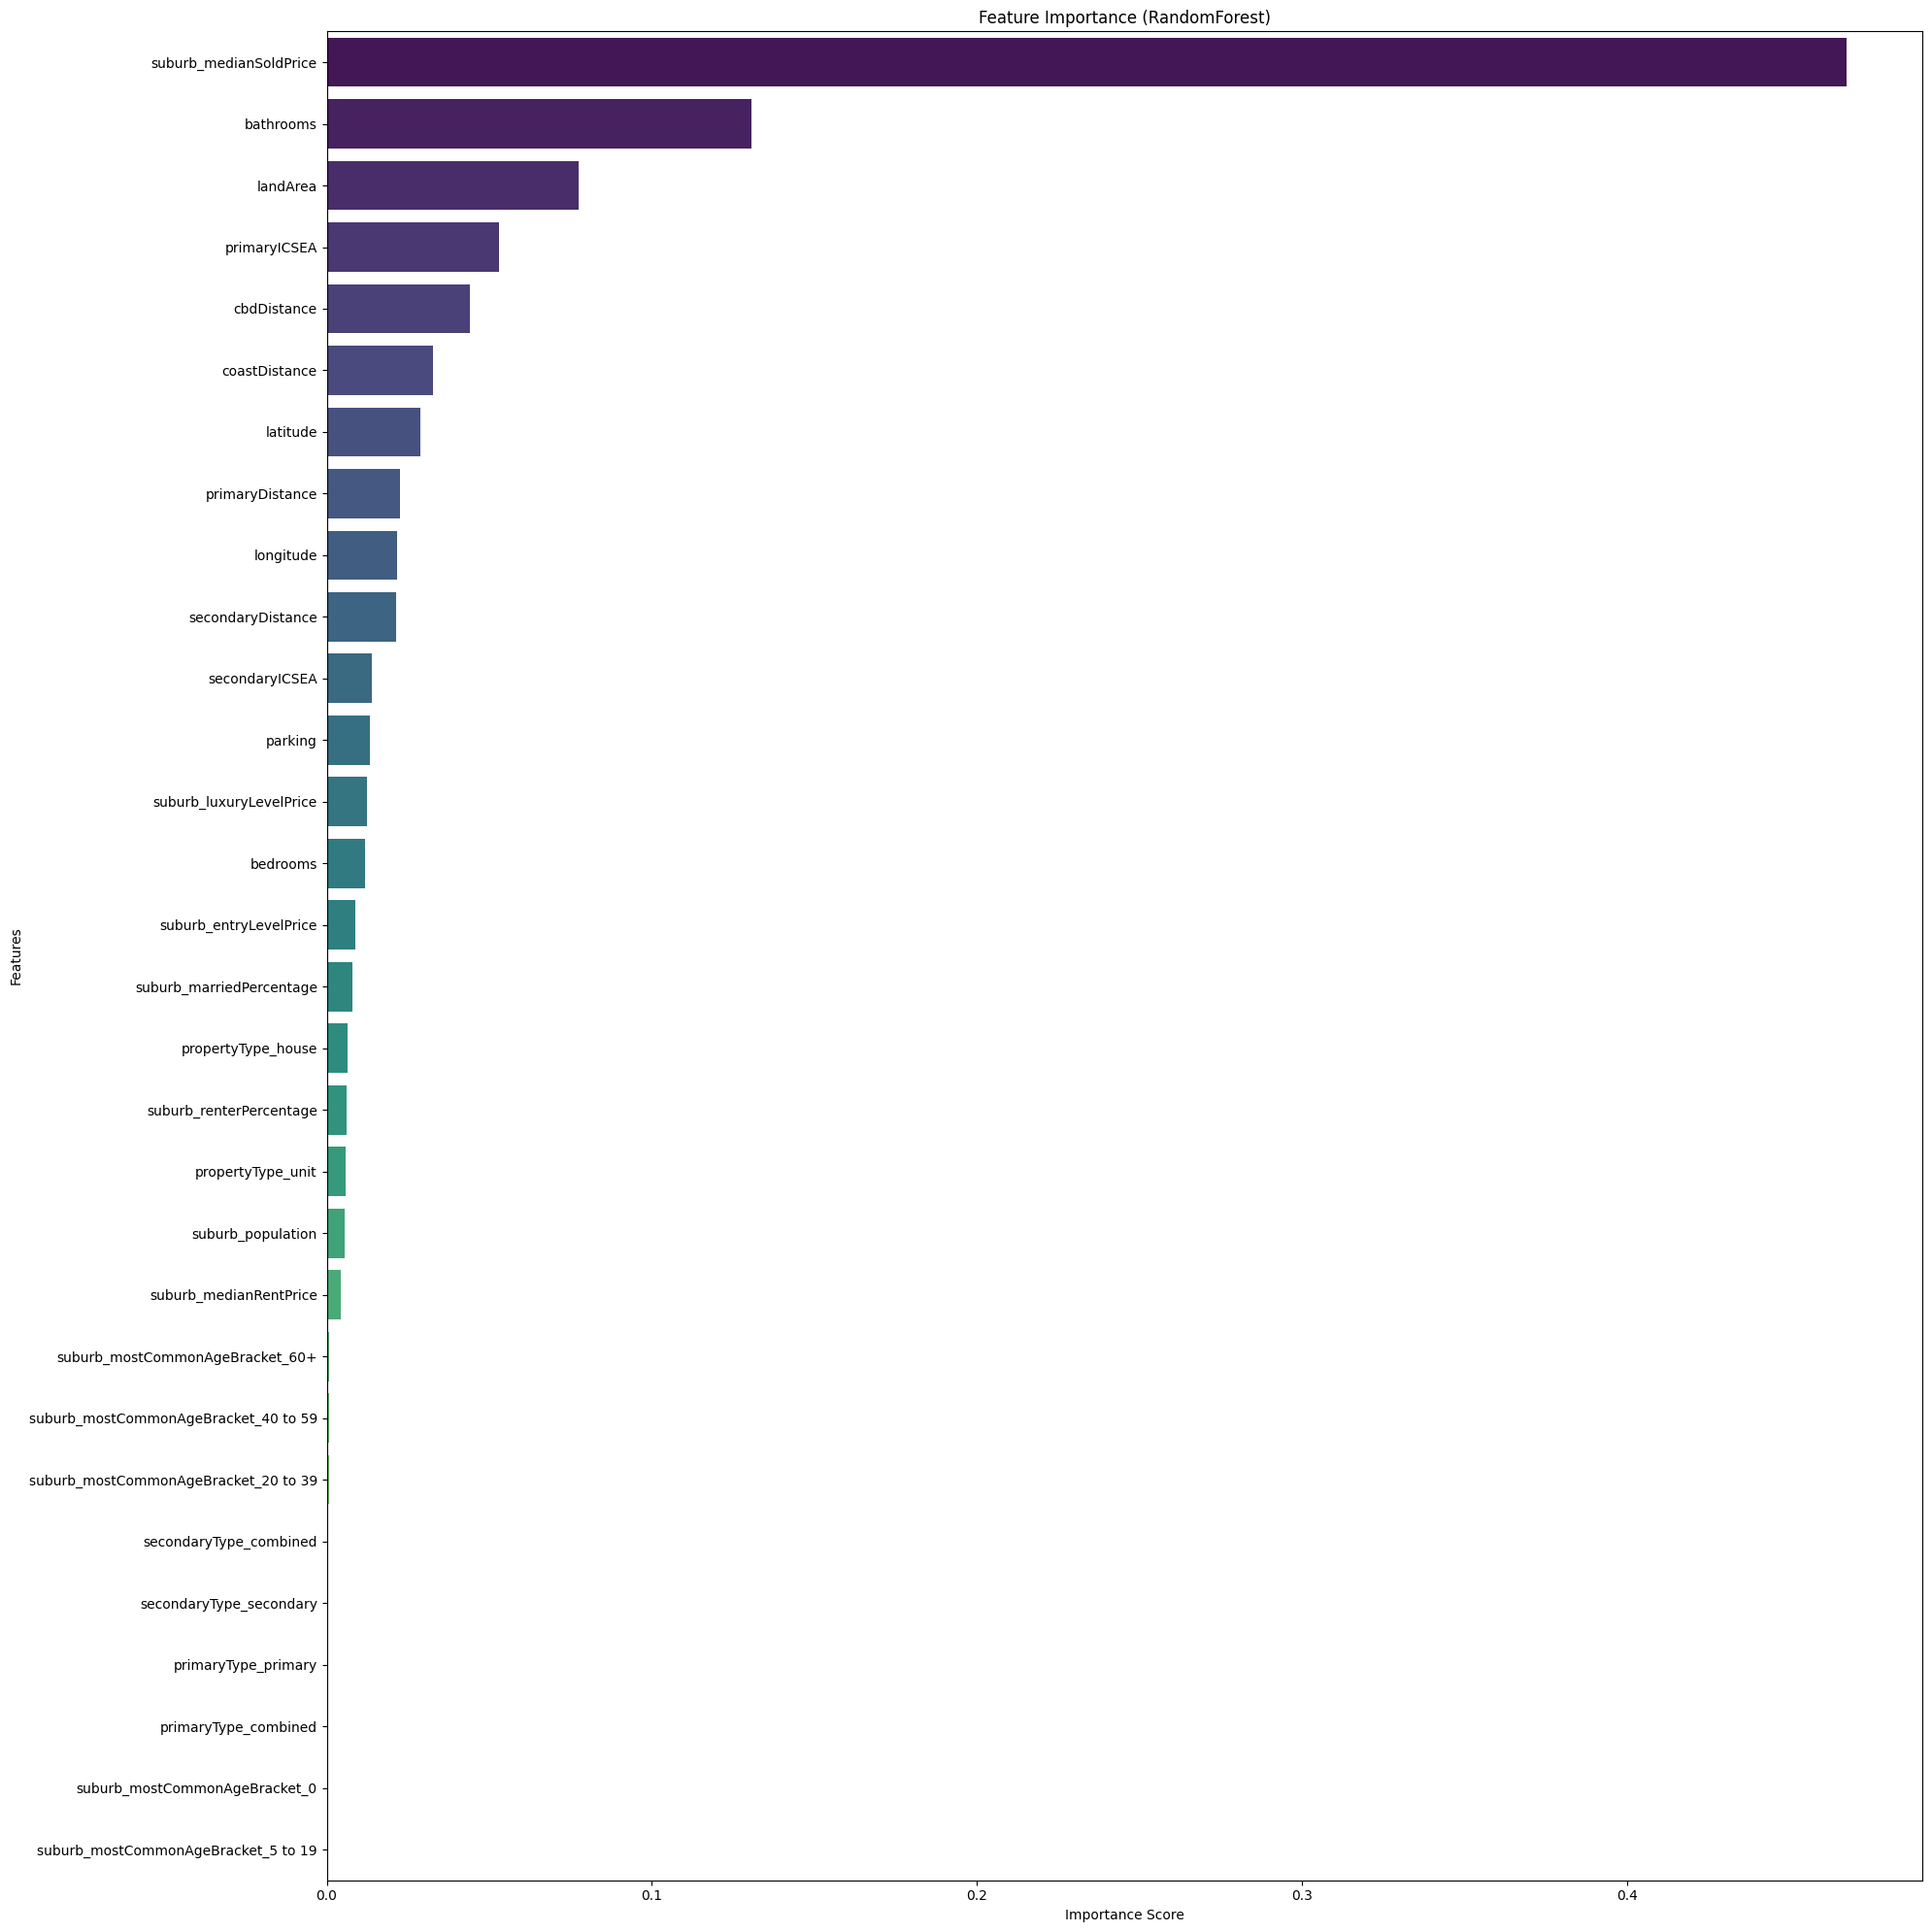

In [16]:
plot_feature_importance(rf_trained, x_train2, 'RandomForest')

### XGBoost

+---------+-------+--------+--------+--------+--------+--------+
| Dataset | Model |  MSE   |  RMSE  |  MAE   |  MAPE  |   R2   |
+---------+-------+--------+--------+--------+--------+--------+
|  Train  |  XGB  | 0.0061 | 0.0781 | 0.0585 | 1.0007 | 0.8733 |
|   Test  |  XGB  | 0.0072 | 0.0849 | 0.0632 | 1.0802 | 0.8531 |
+---------+-------+--------+--------+--------+--------+--------+


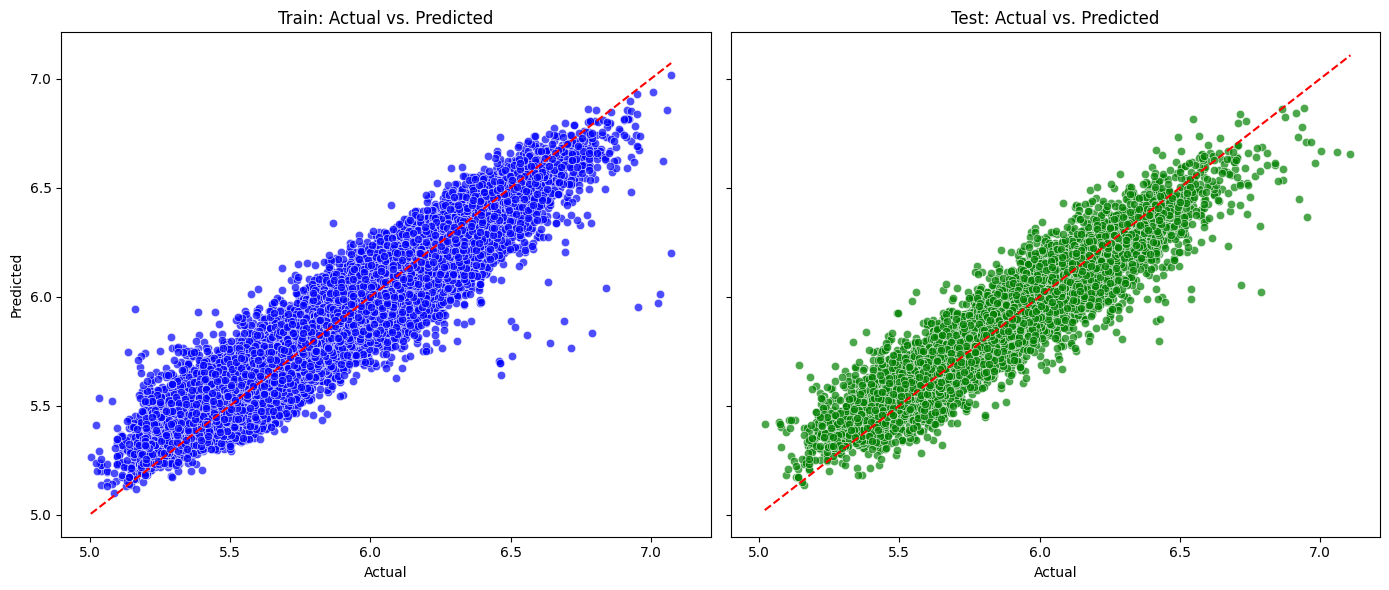

In [17]:
xgb = XGBRegressor()
xgb_trained = evaluate_model(xgb, x_train2, y_train, x_test2, y_test, 'XGB')

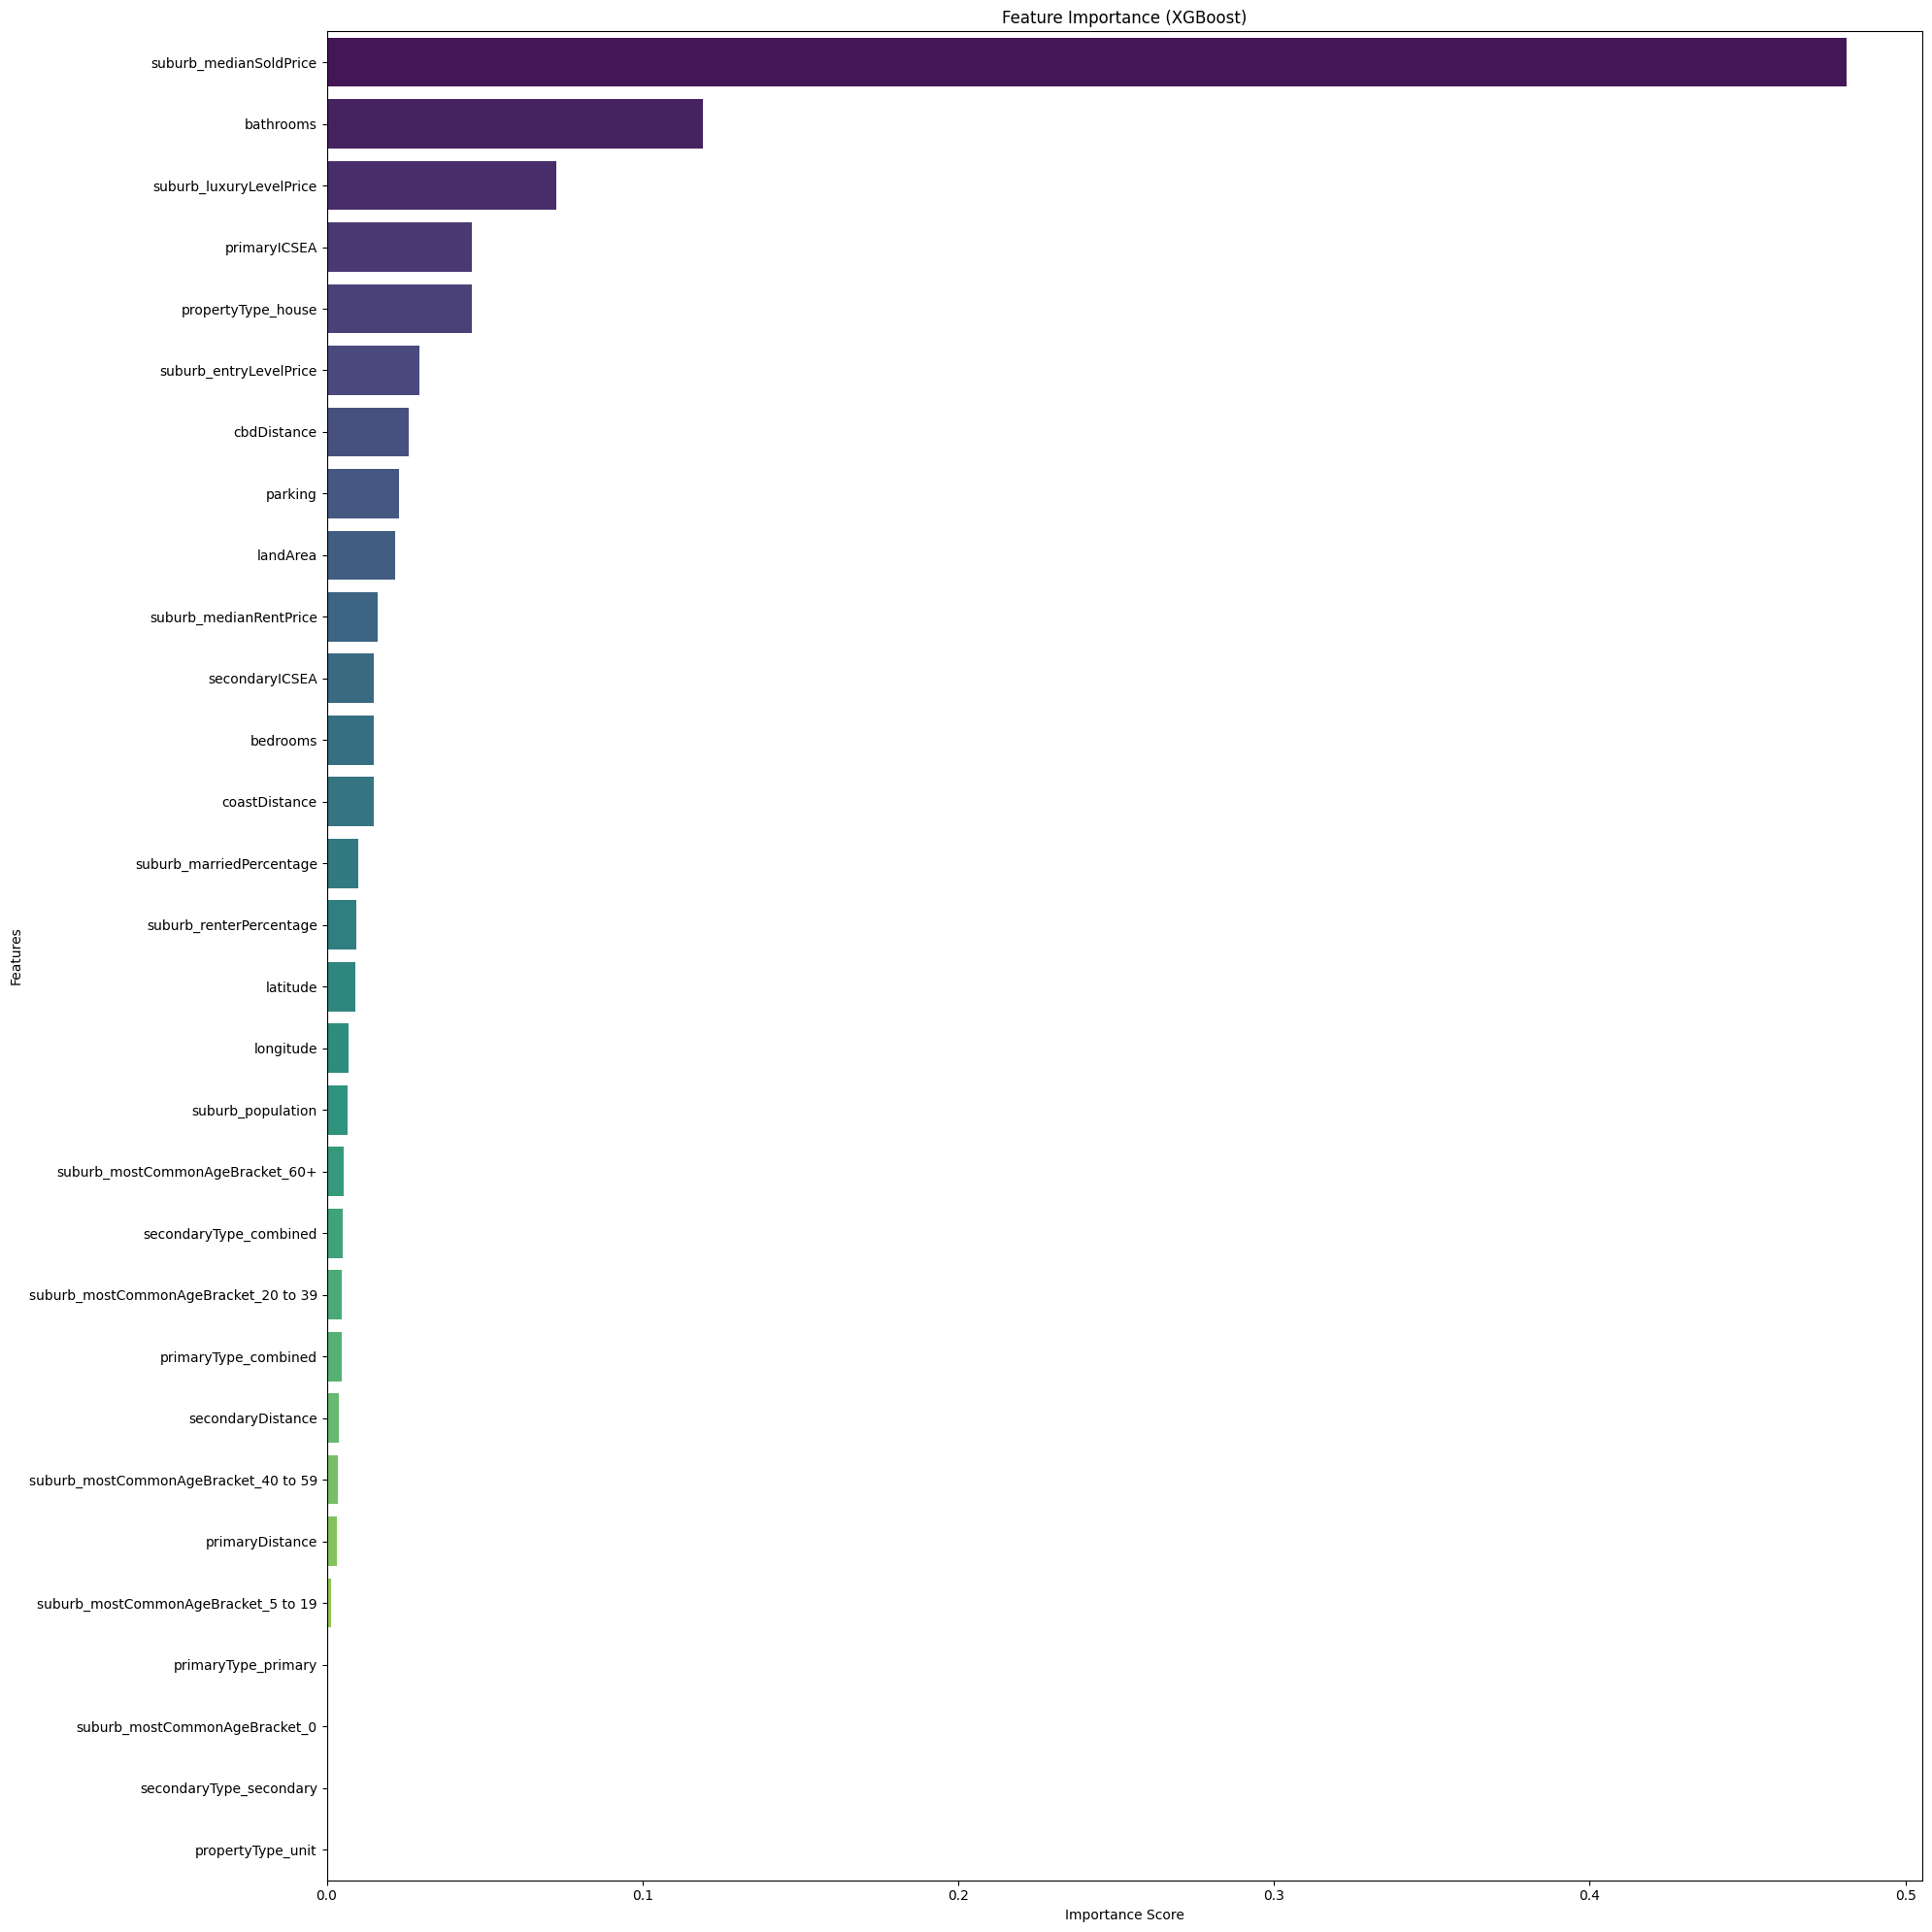

In [18]:
plot_feature_importance(xgb_trained, x_train2, 'XGBoost')

# Hyperparameter tuning

We will only hyperparameter tune xgboost and random forest as they performed the best 

### Random Forest

In [19]:
# rf = RandomForestRegressor()
# param = {
#     'n_estimators': [500, 1000, 2000],
#     'max_depth': [4, 8, 16]
# }

# tuned_model = hyperparameter_tune(rf, param, x_train, y_train)

In [20]:
# plot_search_results(tuned_model)

In [21]:
# rf = tuned_model.best_estimator_
# param = {
#     'min_samples_split': [2, 10, 20]
# }

# tuned_model = hyperparameter_tune(rf, param, x_train, y_train)

In [22]:
# plot_search_results(tuned_model)

Kernel died before this point, however the results were printed

In [23]:
rf = RandomForestRegressor(max_depth=None, n_estimators=2000, min_samples_split=2)
param = {
    'max_features': [0.1, 0.25, 0.5, 0.75, 1]
}

tuned_model = hyperparameter_tune(rf, param, x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...................................max_features=0.1; total time= 6.6min
[CV] END ...................................max_features=0.1; total time= 6.5min
[CV] END ...................................max_features=0.1; total time= 6.5min
[CV] END ...................................max_features=0.1; total time= 6.5min
[CV] END ...................................max_features=0.1; total time= 6.5min
[CV] END ..................................max_features=0.25; total time=13.9min
[CV] END ..................................max_features=0.25; total time=13.9min
[CV] END ..................................max_features=0.25; total time=14.0min
[CV] END ..................................max_features=0.25; total time=14.0min
[CV] END ..................................max_features=0.25; total time=14.0min
[CV] END ...................................max_features=0.5; total time=25.5min
[CV] END ...................................max_f

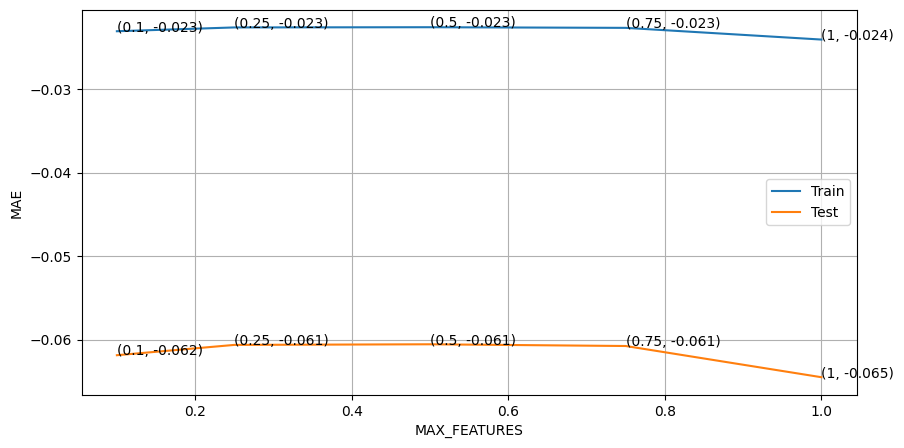

In [24]:
plot_search_results(tuned_model)

+---------+-------+--------+--------+--------+--------+--------+
| Dataset | Model |  MSE   |  RMSE  |  MAE   |  MAPE  |   R2   |
+---------+-------+--------+--------+--------+--------+--------+
|  Train  |   RF  | 0.001  | 0.0316 | 0.0223 | 0.3815 | 0.9799 |
|   Test  |   RF  | 0.0066 | 0.0812 | 0.0591 | 1.0095 | 0.8656 |
+---------+-------+--------+--------+--------+--------+--------+


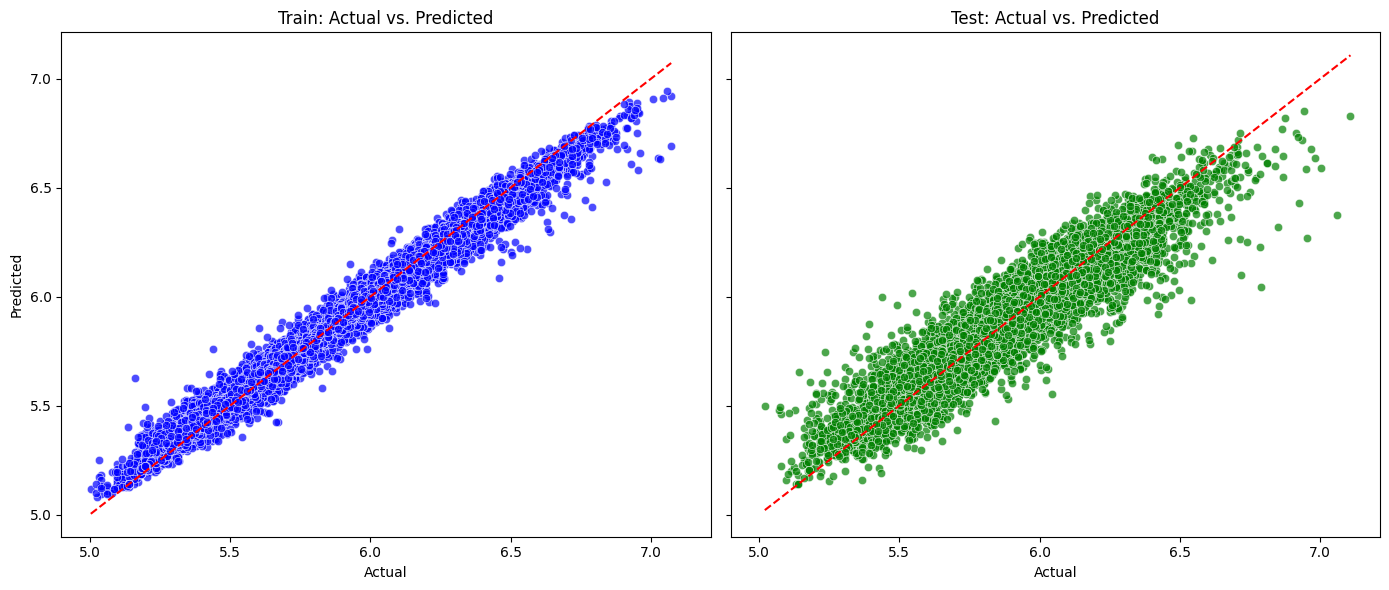

In [25]:
best_rf = tuned_model.best_estimator_
best_rf_trained = evaluate_model(best_rf, x_train, y_train, x_test, y_test, 'RF')

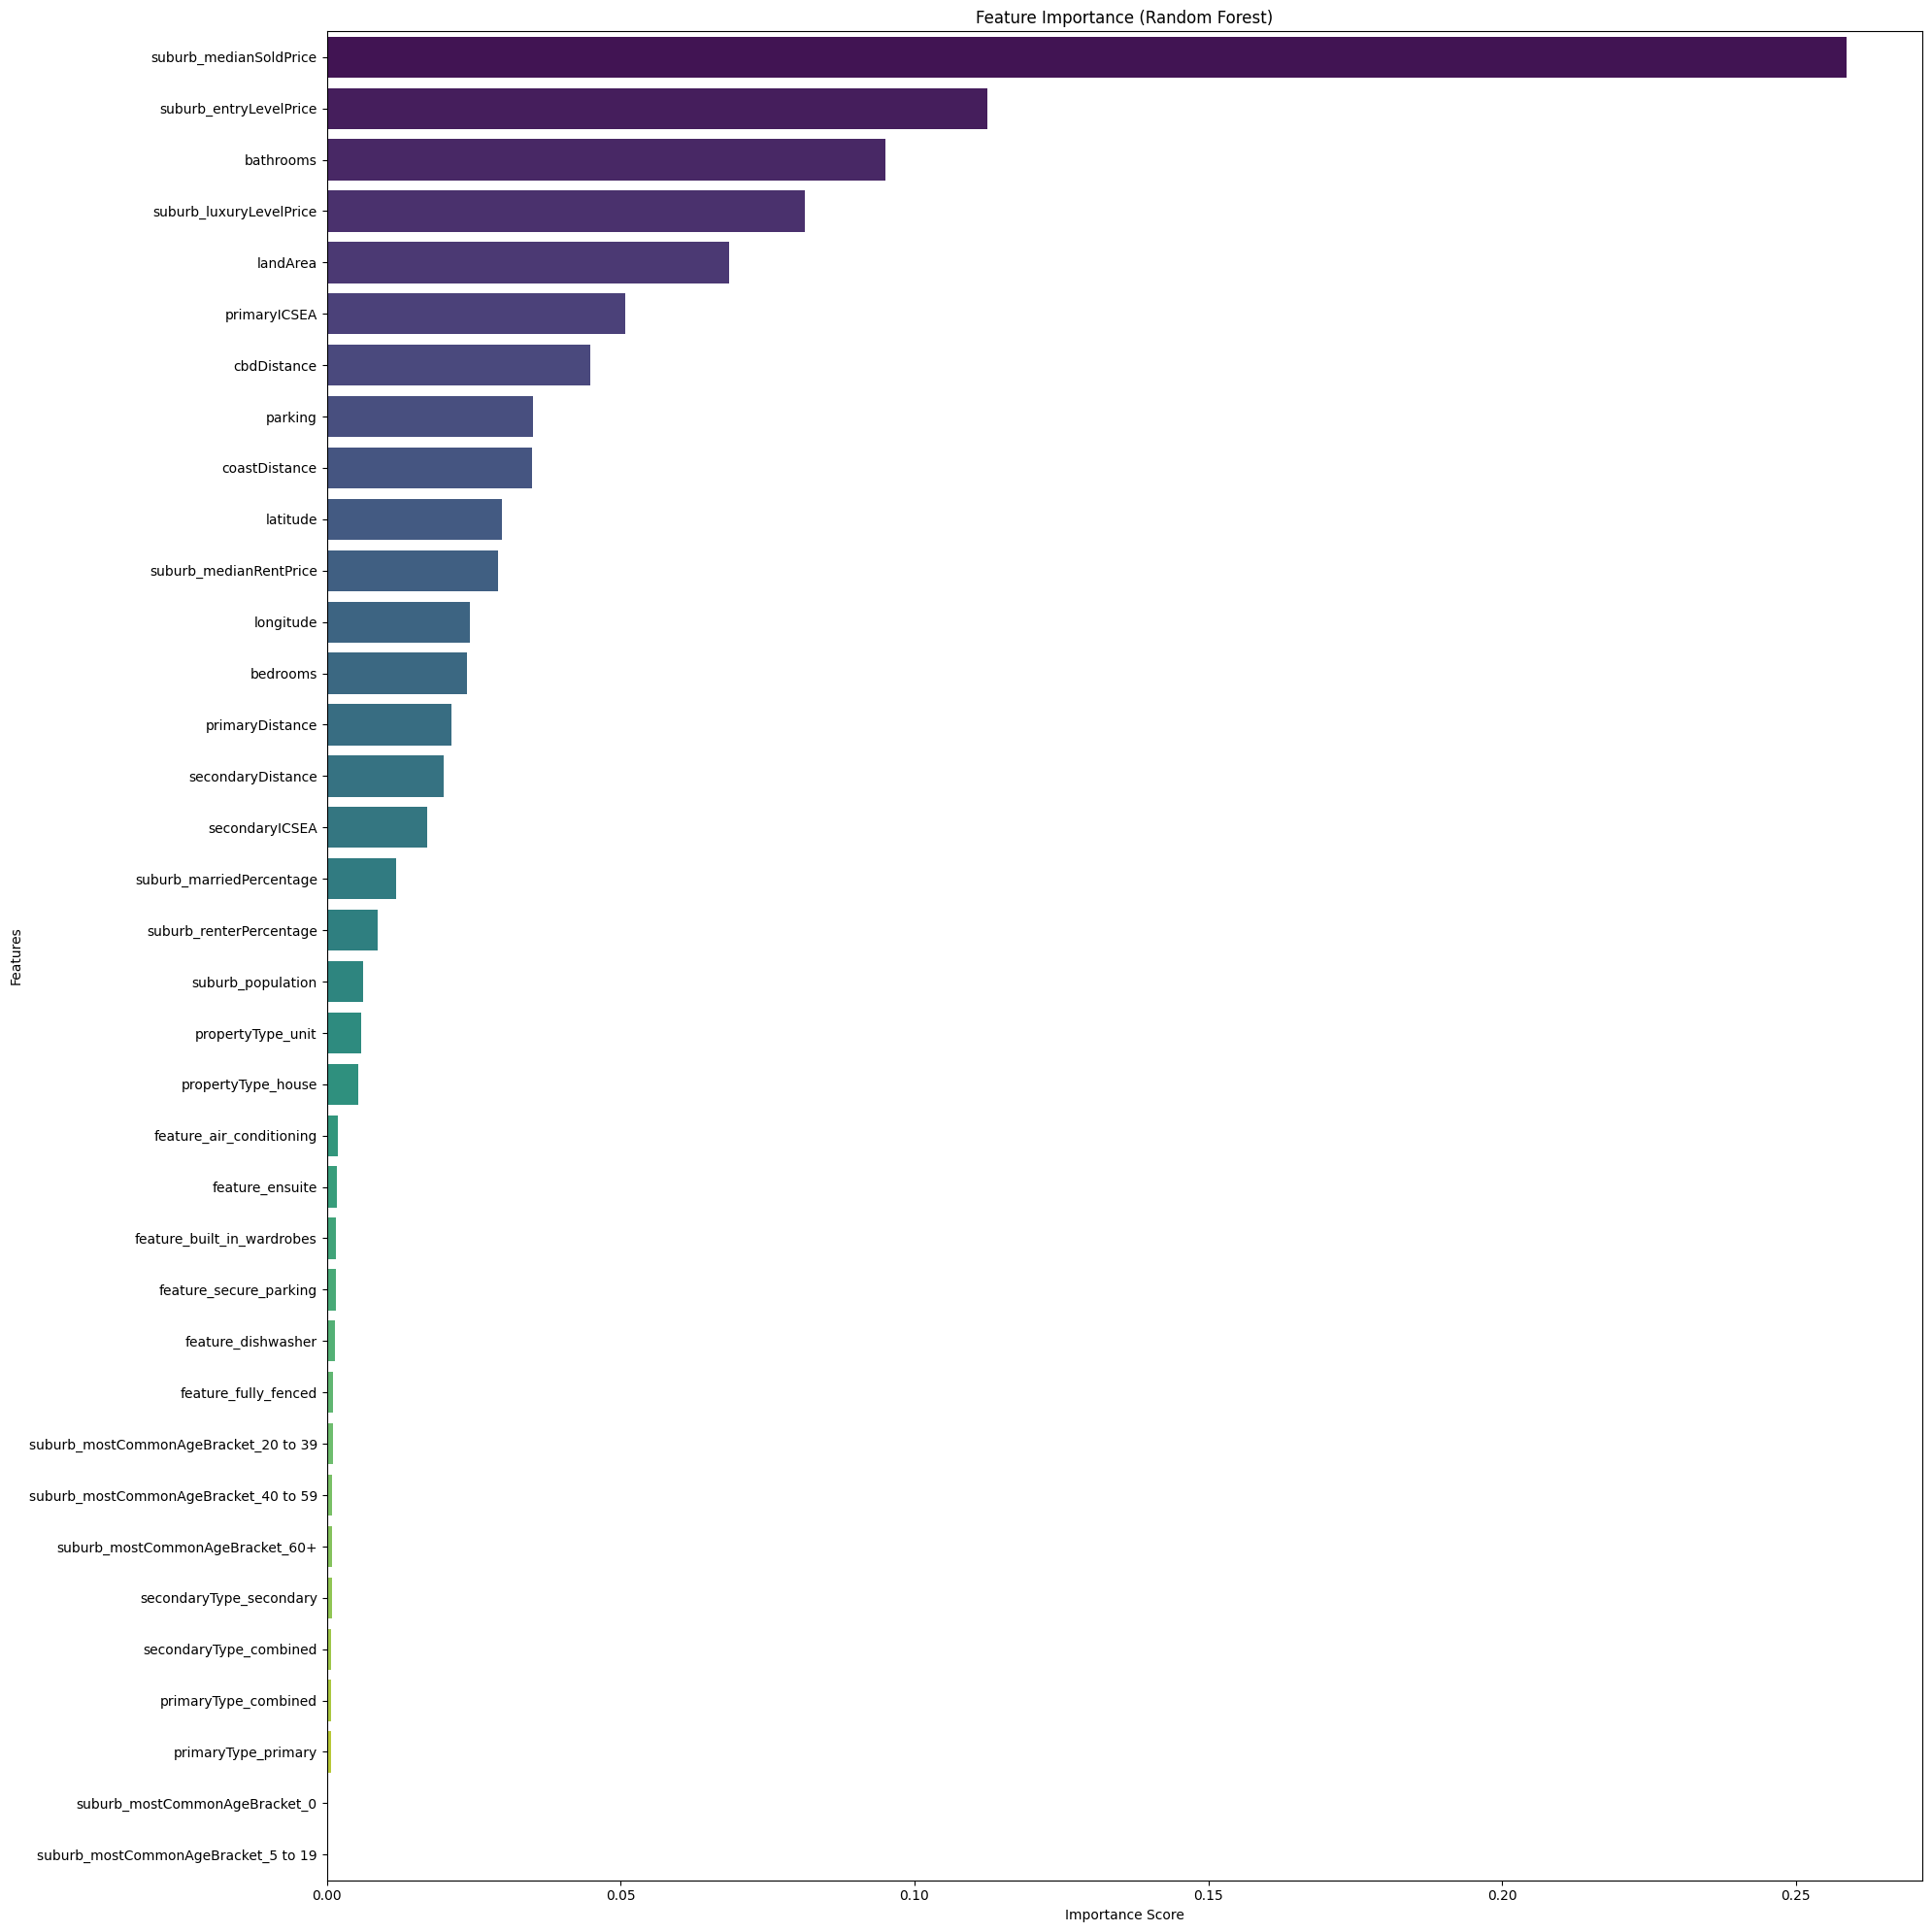

In [26]:
plot_feature_importance(best_rf_trained, x_train, 'Random Forest')

### XGBoost

In [27]:
xgb = XGBRegressor()
param = {
    'max_depth':[4,8,16,32],
    'min_child_weight':[1,10,20,40]
}

tuned_model = hyperparameter_tune(xgb, param, x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ....................max_depth=4, min_child_weight=1; total time=   1.4s
[CV] END ....................max_depth=4, min_child_weight=1; total time=   0.6s
[CV] END ....................max_depth=4, min_child_weight=1; total time=   0.7s
[CV] END ....................max_depth=4, min_child_weight=1; total time=   0.6s
[CV] END ....................max_depth=4, min_child_weight=1; total time=   0.6s
[CV] END ...................max_depth=4, min_child_weight=10; total time=   0.7s
[CV] END ...................max_depth=4, min_child_weight=10; total time=   0.7s
[CV] END ...................max_depth=4, min_child_weight=10; total time=   0.7s
[CV] END ...................max_depth=4, min_child_weight=10; total time=   0.8s
[CV] END ...................max_depth=4, min_child_weight=10; total time=   0.7s
[CV] END ...................max_depth=4, min_child_weight=20; total time=   0.6s
[CV] END ...................max_depth=4, min_chi

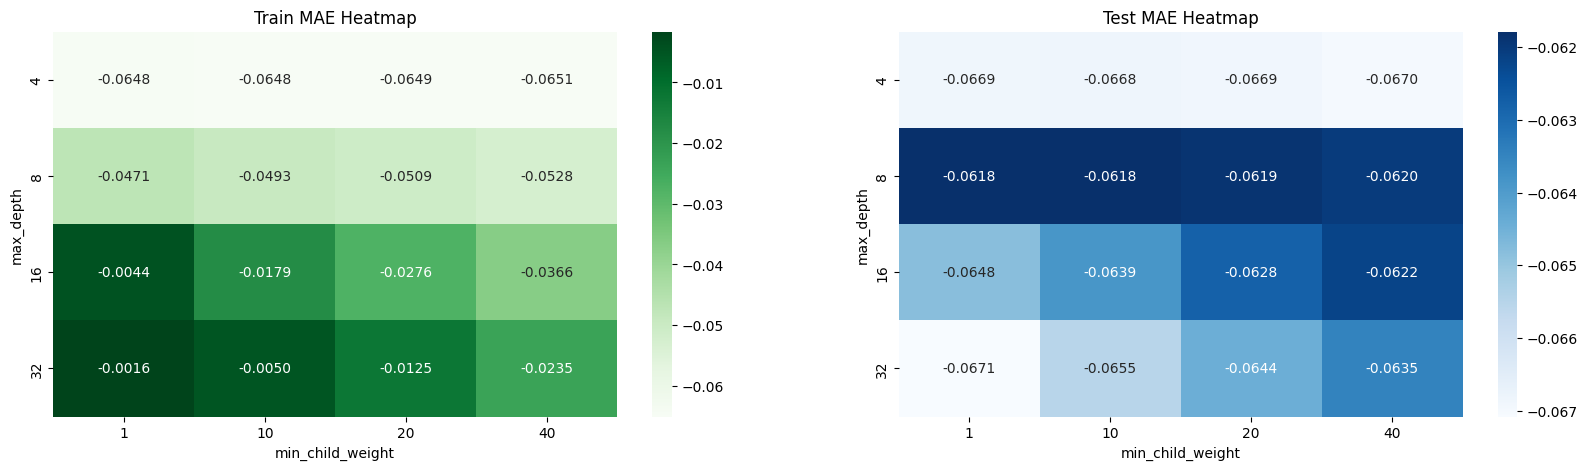

In [28]:
plot_search_results(tuned_model)

In [29]:
xgb = tuned_model.best_estimator_
param = {
    'subsample':[0.1,0.4,0.7,1],
    'colsample_bytree':[0.1,0.4,0.7,1]
}

tuned_model = hyperparameter_tune(xgb, param, x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ................colsample_bytree=0.1, subsample=0.1; total time=   0.9s
[CV] END ................colsample_bytree=0.1, subsample=0.1; total time=   0.9s
[CV] END ................colsample_bytree=0.1, subsample=0.1; total time=   0.8s
[CV] END ................colsample_bytree=0.1, subsample=0.1; total time=   0.8s
[CV] END ................colsample_bytree=0.1, subsample=0.1; total time=   0.9s
[CV] END ................colsample_bytree=0.1, subsample=0.4; total time=   0.9s
[CV] END ................colsample_bytree=0.1, subsample=0.4; total time=   0.9s
[CV] END ................colsample_bytree=0.1, subsample=0.4; total time=   0.9s
[CV] END ................colsample_bytree=0.1, subsample=0.4; total time=   0.9s
[CV] END ................colsample_bytree=0.1, subsample=0.4; total time=   0.9s
[CV] END ................colsample_bytree=0.1, subsample=0.7; total time=   0.9s
[CV] END ................colsample_bytree=0.1, s

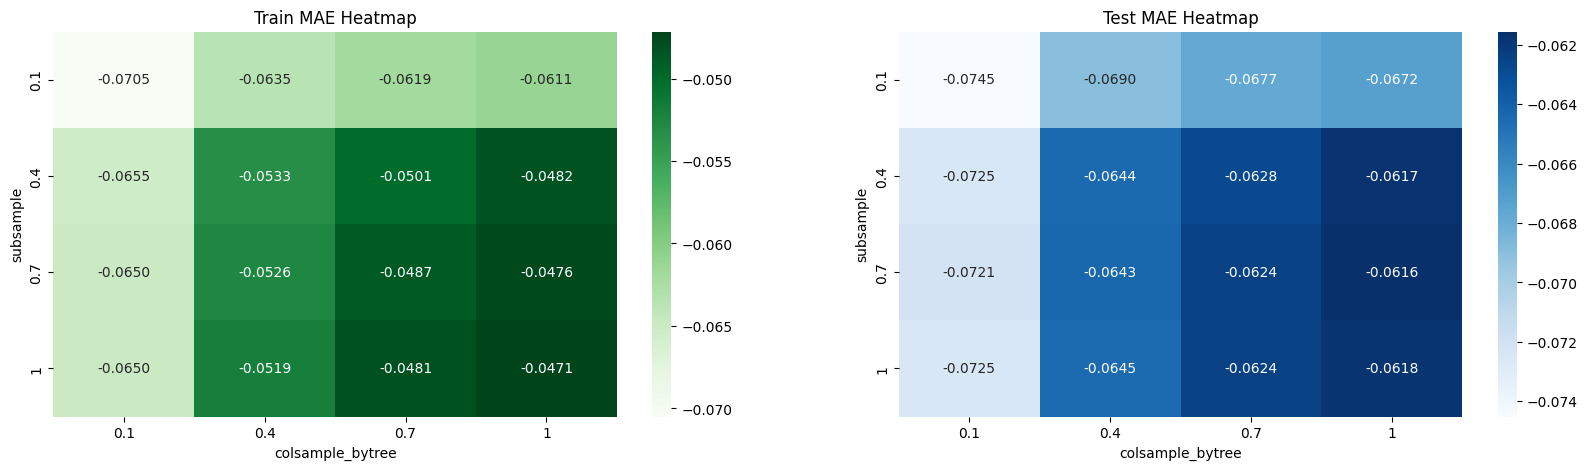

In [30]:
plot_search_results(tuned_model)

In [31]:
xgb = tuned_model.best_estimator_
param = {
    'n_estimators':[50,100,200,400,800]
}

tuned_model = hyperparameter_tune(xgb, param, x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ....................................n_estimators=50; total time=   1.0s
[CV] END ....................................n_estimators=50; total time=   1.1s
[CV] END ....................................n_estimators=50; total time=   1.0s
[CV] END ....................................n_estimators=50; total time=   1.1s
[CV] END ....................................n_estimators=50; total time=   1.1s
[CV] END ...................................n_estimators=100; total time=   1.8s
[CV] END ...................................n_estimators=100; total time=   1.8s
[CV] END ...................................n_estimators=100; total time=   1.7s
[CV] END ...................................n_estimators=100; total time=   1.4s
[CV] END ...................................n_estimators=100; total time=   1.3s
[CV] END ...................................n_estimators=200; total time=   2.3s
[CV] END ...................................n_est

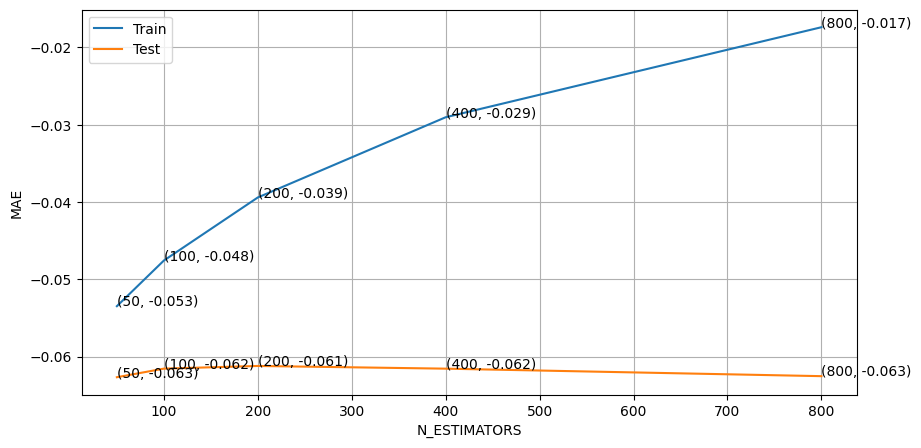

In [32]:
plot_search_results(tuned_model)

+---------+-------+--------+--------+--------+--------+--------+
| Dataset | Model |  MSE   |  RMSE  |  MAE   |  MAPE  |   R2   |
+---------+-------+--------+--------+--------+--------+--------+
|  Train  |  XGB  | 0.003  | 0.0548 | 0.0416 | 0.7127 | 0.9375 |
|   Test  |  XGB  | 0.0066 | 0.0812 | 0.0601 | 1.0262 | 0.8649 |
+---------+-------+--------+--------+--------+--------+--------+


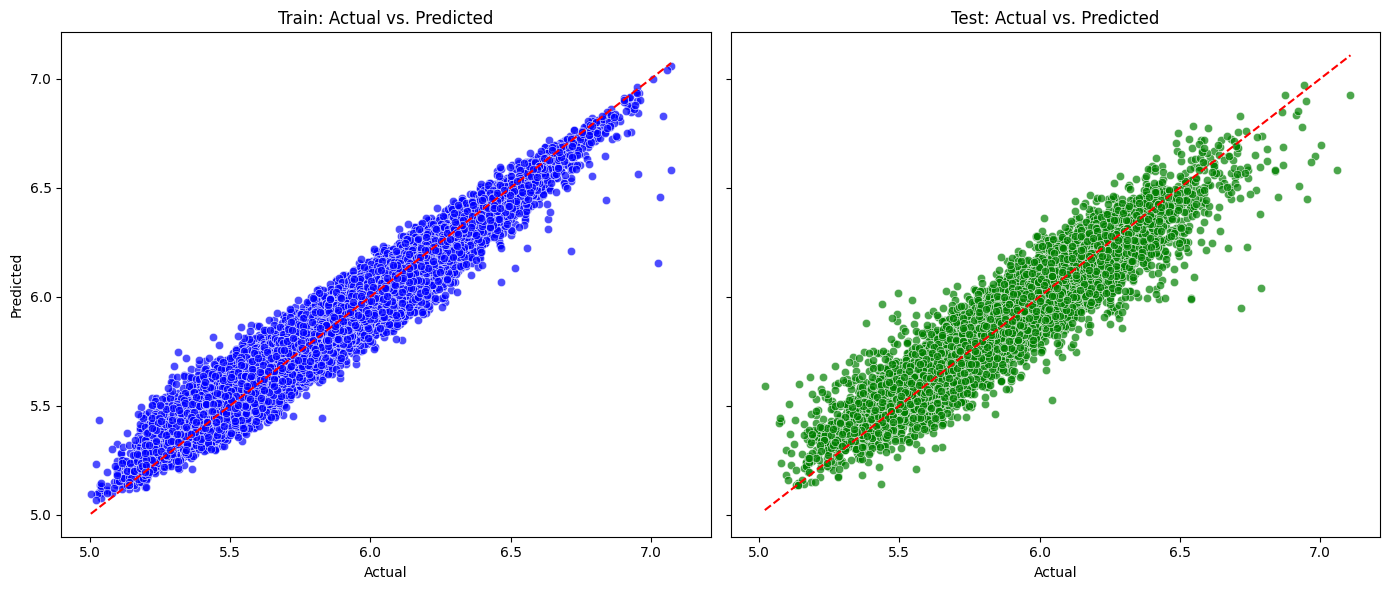

In [33]:
best_xgb = tuned_model.best_estimator_
best_xgb_trained = evaluate_model(best_xgb, x_train, y_train, x_test, y_test, 'XGB')

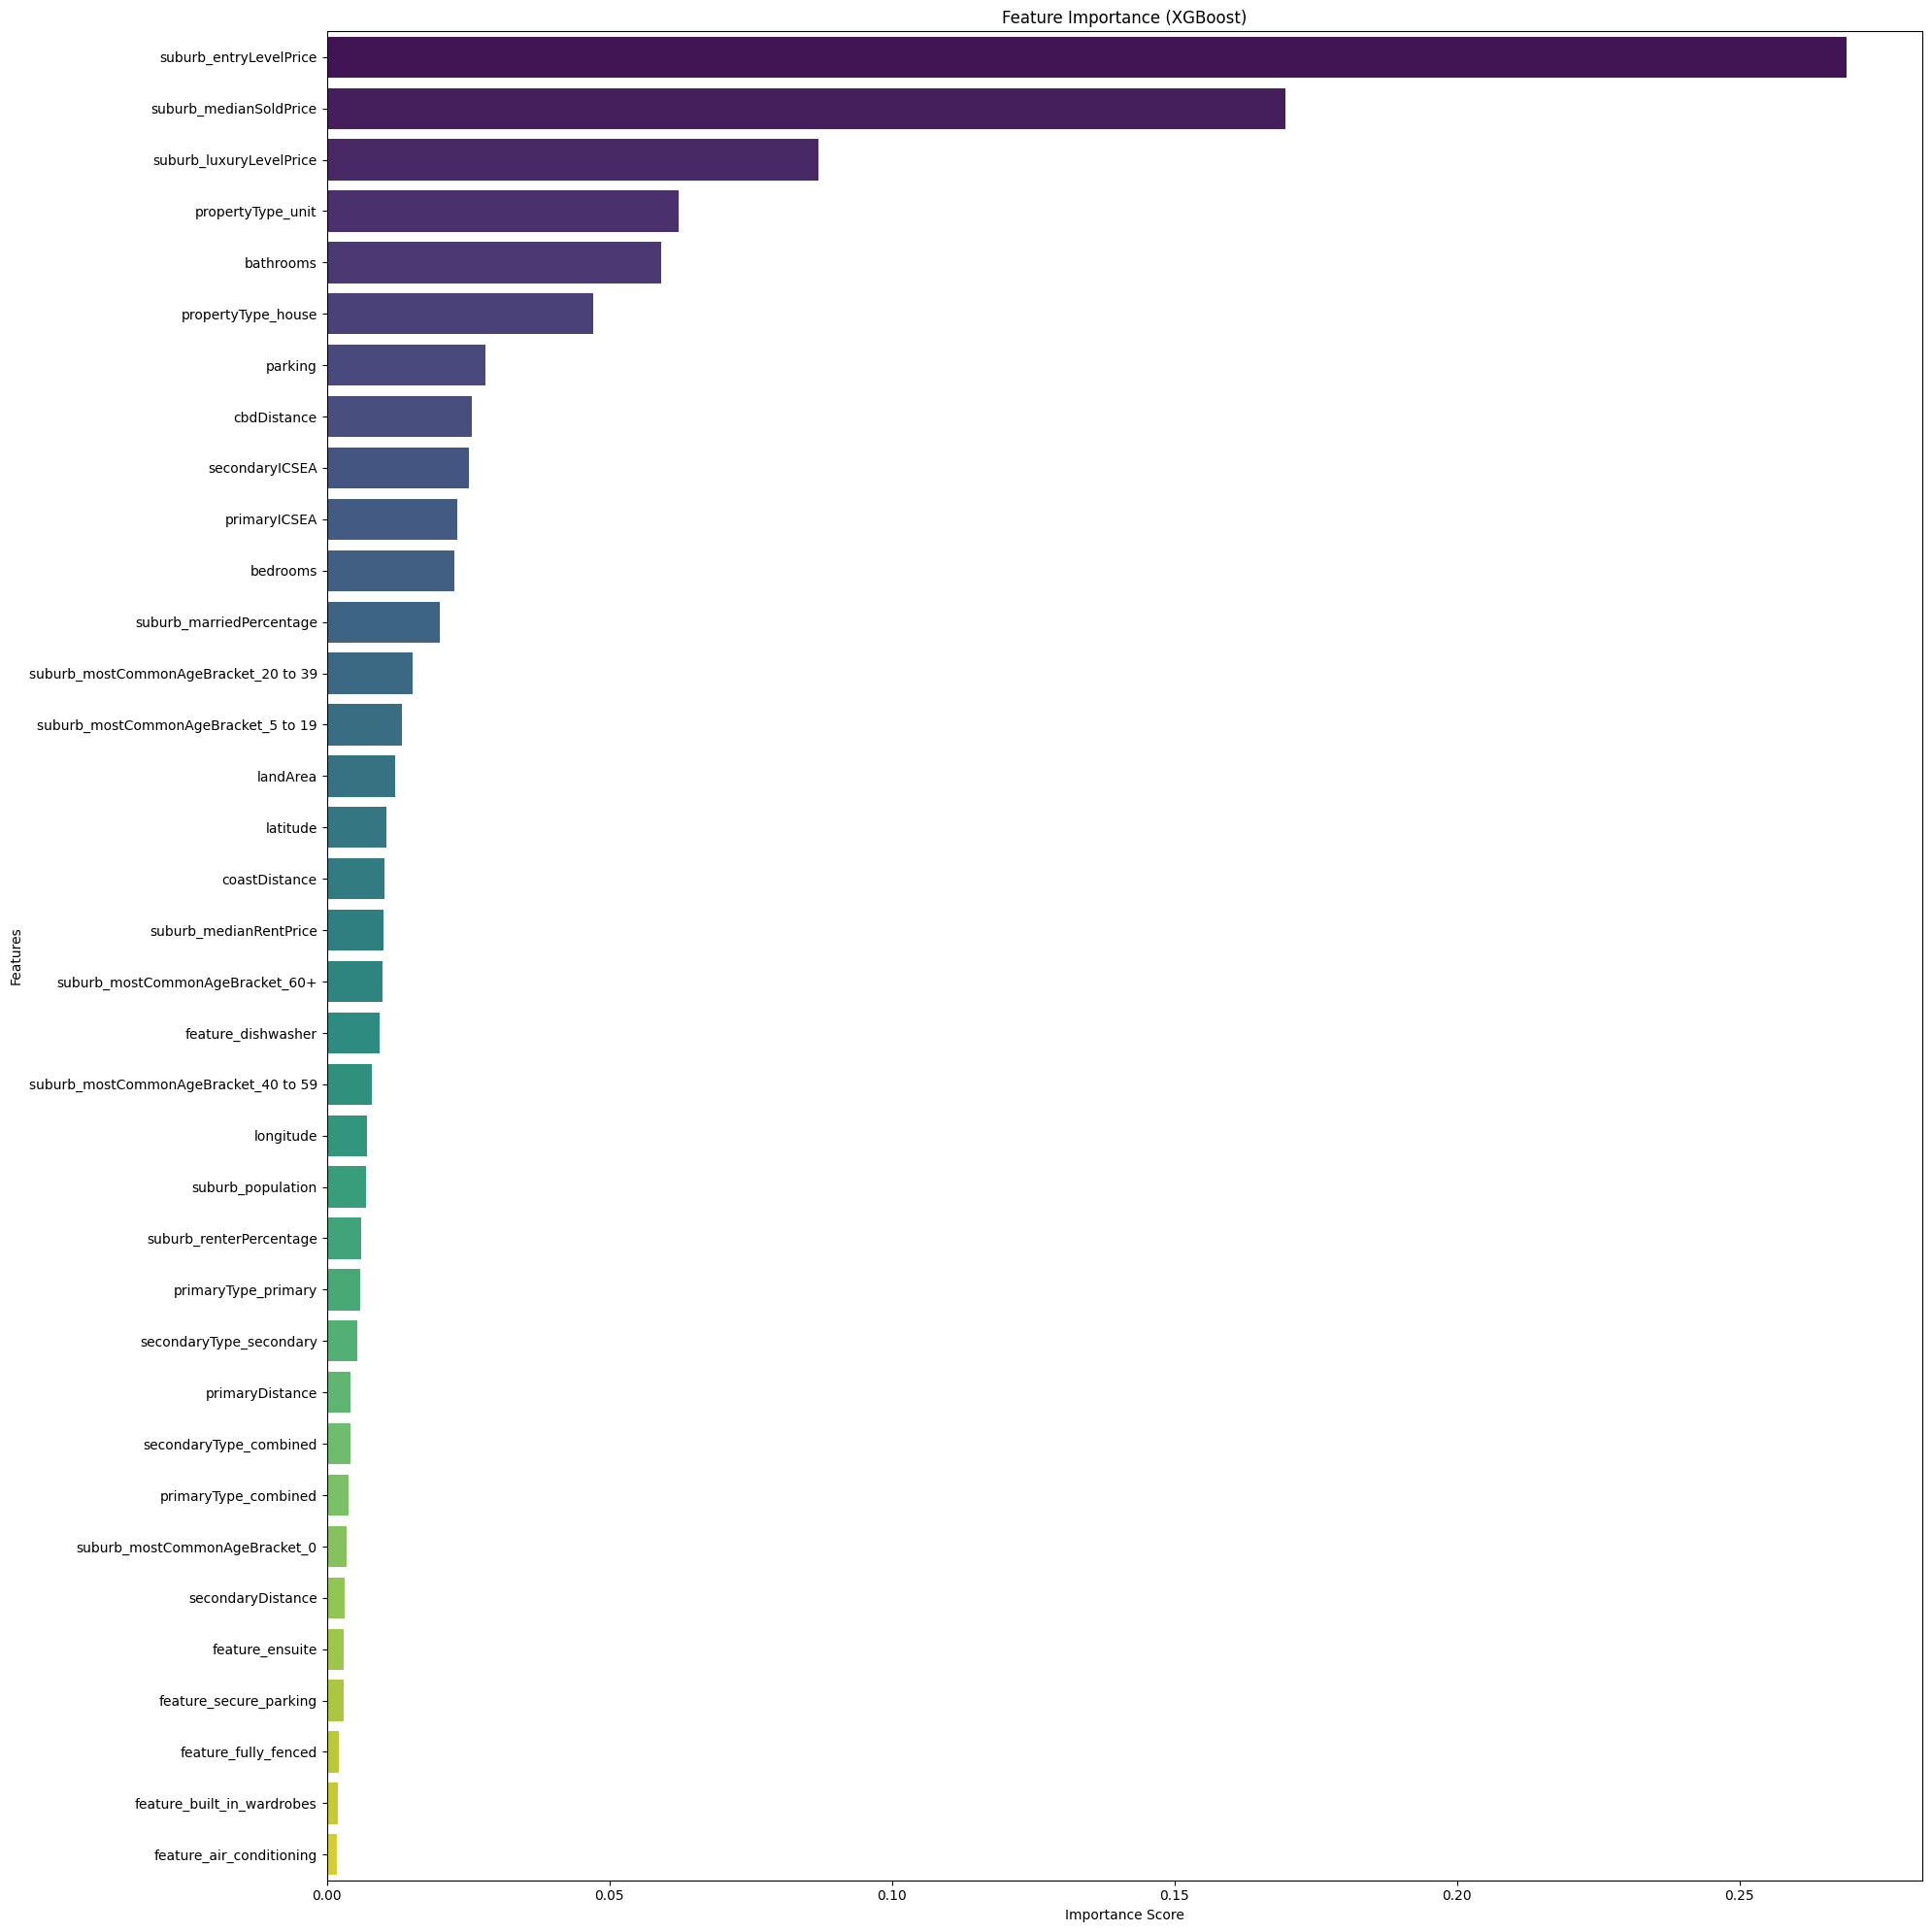

In [34]:
plot_feature_importance(best_xgb_trained, x_train, 'XGBoost')